In [346]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import chi2_contingency
import warnings

warnings.filterwarnings('ignore')

In [347]:
#pip uninstall scikit-learn

In [348]:
#pip install scikit-learn==1.2.2

In [349]:
data=pd.read_csv("online_shoppers_intention.csv")

In [350]:
data.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [351]:
data.shape


(12330, 18)

In [352]:
print(data.duplicated().sum())


125


In [353]:
data=data.drop_duplicates()

In [354]:
data.shape

(12205, 18)

In [355]:
numerical_columns=['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical_columns=['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend','Revenue']

In [356]:
data['Revenue'].value_counts()

Revenue
False    10297
True      1908
Name: count, dtype: int64

In [357]:
data['VisitorType'].value_counts()

VisitorType
Returning_Visitor    10431
New_Visitor           1693
Other                   81
Name: count, dtype: int64

In [358]:
data['Weekend'].value_counts()

Weekend
False    9346
True     2859
Name: count, dtype: int64

In [359]:
# IQR function 
def IQR(x):
    x = x.astype(np.float32)
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    bb = q1 - 1.5*(q3 - q1)
    ba = q3 + 1.5*(q3 - q1)
    outlier_indices = list(x.index[(x < bb) | (x > ba)])
    outlier_values = list(x[outlier_indices])
    return len(outlier_indices)

In [360]:
total_outliers=0
for i in numerical_columns:
    print(f'Number of IQR outliers {i}: {IQR(data[i])}')

Number of IQR outliers Administrative: 404
Number of IQR outliers Administrative_Duration: 1149
Number of IQR outliers Informational: 2631
Number of IQR outliers Informational_Duration: 2405
Number of IQR outliers ProductRelated: 1007
Number of IQR outliers ProductRelated_Duration: 951
Number of IQR outliers BounceRates: 1428
Number of IQR outliers ExitRates: 1325
Number of IQR outliers PageValues: 2730
Number of IQR outliers SpecialDay: 1249


In [361]:
total_outliers = 0
total_data_points = 0

for i in numerical_columns:
    outliers = IQR(data[i])
    total_outliers += outliers
    total_data_points += len(data[i])

total_outlier_percentage = (total_outliers / total_data_points) * 100

print(f'Total outlier percentage: {total_outlier_percentage:.2f}%')

Total outlier percentage: 12.52%


In [362]:
class AddNewVariables(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['Administrative_Duration_Page'] = X['Administrative_Duration']/data['Administrative']
        X['Informational_Duration_Page'] = X['Informational_Duration']/data['Informational']
        X['ProductRelated_Duration_Page'] = X['ProductRelated_Duration']/data['ProductRelated']
        
        # division by zero becomes zero
        X['Administrative_Duration_Page'] = X['Administrative_Duration_Page'].fillna(0)
        X['Informational_Duration_Page'] = X['Informational_Duration_Page'].fillna(0)
        X['ProductRelated_Duration_Page'] = X['ProductRelated_Duration_Page'].fillna(0)
     
        return X


In [363]:
class DropVariables(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.drop(columns=self.columns_to_drop)

In [364]:
class oneHot(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.encoder = OneHotEncoder(sparse=False, drop='first')

    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        onehot_encoded = self.encoder.transform(X[self.columns])
        feature_names = self.encoder.get_feature_names_out()
        result_df = pd.DataFrame(onehot_encoded, columns=feature_names, index=X.index)
        return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

In [365]:
class StdScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        if (self.columns is None):
            num_cols = [i for i in X.columns if len(np.unique(X[i])) > 5]
            self.columns = num_cols
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        scaled_data = self.scaler.transform(X[self.columns])
        result_df = pd.DataFrame(scaled_data, columns=self.columns, index=X.index)
        return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

In [366]:
zero_rows_indices = data[(data[['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration']] == 0.0).all(axis=1)].index


data = data.drop(zero_rows_indices)

In [367]:
data.shape

(12199, 18)

In [368]:
X = data.drop(['Revenue'], axis = 1)
y = data['Revenue']

In [369]:
count_zero_rows = (data[['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration']]==0.000000).all(axis=1).sum()
print(count_zero_rows)

0


In [370]:
y

0        False
1        False
2        False
3        False
4        False
         ...  
12325    False
12326    False
12327    False
12328    False
12329    False
Name: Revenue, Length: 12199, dtype: bool

In [371]:
y.shape

(12199,)

In [372]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [373]:
pipe = Pipeline([
    ('add_new_vars', AddNewVariables()),
    ('drop_old_vars', DropVariables(columns_to_drop=['Administrative', 'Informational', 'ProductRelated', 'Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration'])),
    ('oneHot',oneHot(columns=['Weekend','Month','VisitorType'])),
    ('scaler',StdScaler())
])

In [374]:
pipe1 = clone(pipe)

In [375]:
x_train

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
3134,0,0.000000,0,0.0,4,118.000000,0.050000,0.066667,0.000000,0.0,May,1,1,2,3,Returning_Visitor,False
7088,3,75.400000,0,0.0,18,1051.420000,0.009524,0.019048,0.000000,0.0,Oct,2,5,2,2,New_Visitor,False
3077,0,0.000000,0,0.0,5,215.000000,0.040000,0.080000,0.000000,0.6,May,3,2,3,2,Returning_Visitor,False
4775,1,21.000000,0,0.0,31,945.666667,0.006897,0.010345,0.000000,0.0,May,2,2,1,4,New_Visitor,False
9917,0,0.000000,0,0.0,2,11.000000,0.000000,0.100000,0.000000,0.0,Nov,3,2,1,10,Returning_Visitor,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12092,0,0.000000,0,0.0,11,332.125000,0.036364,0.090909,0.000000,0.0,Nov,2,2,6,3,Returning_Visitor,False
5274,1,48.000000,0,0.0,26,1066.666667,0.025000,0.042024,0.000000,0.0,May,3,2,8,11,Returning_Visitor,False
5477,7,227.900000,0,0.0,22,701.016667,0.000000,0.001667,0.000000,0.0,Oct,2,4,4,2,Returning_Visitor,False
874,3,64.500000,0,0.0,35,1334.551371,0.000000,0.007310,0.000000,0.0,Mar,3,2,4,2,Returning_Visitor,True


In [376]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [377]:
X_train

,Weekend_True,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,...,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Administrative_Duration_Page,Informational_Duration_Page,ProductRelated_Duration_Page
3134,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.543101,-0.317612,-0.307020,-1.247215,-0.800120,-0.473492,-0.270193,-0.470635,-0.22189,-0.189580
7088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.484134,-0.317612,-0.307020,-0.138652,1.545910,-0.473492,-0.515952,0.119281,-0.22189,0.452960
3077,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.830727,-0.317612,2.722614,0.969912,-0.213613,-0.056930,-0.515952,-0.470635,-0.22189,0.110442
4775,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.671870,-0.317612,-0.307020,-0.138652,-0.213613,-0.890053,-0.024435,0.022266,-0.22189,-0.167236
9917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.262165,-0.317612,-0.307020,0.969912,-0.213613,-0.890053,1.450116,-0.470635,-0.22189,-0.722951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.066057,-0.317612,-0.307020,-0.138652,-0.213613,1.192754,-0.270193,-0.470635,-0.22189,-0.174175
5274,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.011507,-0.317612,-0.307020,0.969912,-0.213613,2.025877,1.695875,0.655995,-0.22189,0.066564
5477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.859075,-0.317612,-0.307020,-0.138652,0.959403,0.359631,-0.515952,0.293529,-0.22189,-0.137034
874,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.737346,-0.317612,-0.307020,0.969912,-0.213613,0.359631,-0.515952,0.034002,-0.22189,0.002213


In [378]:
# y_train=LabelEncoder().fit_transform(y_train)
# y_test=LabelEncoder().fit_transform(y_test)

In [379]:
y_train

3134     False
7088     False
3077     False
4775     False
9917     False
         ...  
12092    False
5274     False
5477     False
874      False
7361      True
Name: Revenue, Length: 8539, dtype: bool

In [380]:
# #true-1 false-0

# X_train['Weekend'] = LabelEncoder().fit_transform(X_train['Weekend'])
     

# # label encoding for Month
# mapping_month = {'Jan' : 1, 'Feb' : 2,
#                  'Mar' : 3, 'Apr' : 4,
#                  'May' : 5, 'June' : 6,
#                  'Jul' : 7, 'Aug' : 8,
#                  'Sep' : 9, 'Oct' : 10,
#                  'Nov' : 11, 'Dec' : 12}

# X_train['Month'] = X_train['Month'].map(mapping_month)

# X_test['Weekend'] = LabelEncoder().fit_transform(X_test['Weekend'])
     

# # label encoding for Month
# mapping_month = {'Jan' : 1, 'Feb' : 2,
#                  'Mar' : 3, 'Apr' : 4,
#                  'May' : 5, 'June' : 6,
#                  'Jul' : 7, 'Aug' : 8,
#                  'Sep' : 9, 'Oct' : 10,
#                  'Nov' : 11, 'Dec' : 12}

# X_test['Month'] = X_test['Month'].map(mapping_month)

In [381]:
# X_train

In [382]:
# one_hot_encoded_data =pd.get_dummies(X_train['VisitorType'],prefix="VType")
# X_train = X_train.join(one_hot_encoded_data)
# X_train = X_train.drop(['VisitorType'], axis = 1)

# one_hot_encoded_data =pd.get_dummies(X_test['VisitorType'],prefix="VType")
# X_test = X_test.join(one_hot_encoded_data)
# X_test = X_test.drop(['VisitorType'], axis = 1)

In [383]:
# X_train['VType_New_Visitor'] = LabelEncoder().fit_transform(X_train['VType_New_Visitor'])
# X_train['VType_Other'] = LabelEncoder().fit_transform(X_train['VType_Other'])
# X_train['VType_Returning_Visitor'] = LabelEncoder().fit_transform(X_train['VType_Returning_Visitor'])


# X_test['VType_New_Visitor'] = LabelEncoder().fit_transform(X_test['VType_New_Visitor'])
# X_test['VType_Other'] = LabelEncoder().fit_transform(X_test['VType_Other'])
# X_test['VType_Returning_Visitor'] = LabelEncoder().fit_transform(X_test['VType_Returning_Visitor'])


In [384]:
numerical_columns=['Administrative_Duration_Page',
       'Informational_Duration_Page', 'ProductRelated_Duration_Page',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

In [385]:
# X_train_numerical = X_train[numerical_columns]
# scaler = StandardScaler()
# X_train_numerical_scaled = scaler.fit_transform(X_train_numerical)
# X_train[numerical_columns] = X_train_numerical_scaled


# X_test_numerical = X_test[numerical_columns]
# scaler = StandardScaler()
# X_test_numerical_scaled = scaler.fit_transform(X_test_numerical)
# X_test[numerical_columns] = X_test_numerical_scaled

In [386]:
X_train.shape

(8539, 23)

In [387]:
smt=SMOTE()
X_train_smote,y_train_smote=smt.fit_resample(X_train,y_train)

In [388]:
X_train_smote.shape

(14364, 23)

In [389]:
print('AFTER oversampling (smote)')
print(pd.Series(y_train_smote).value_counts())

AFTER oversampling (smote)
Revenue
False    7182
True     7182
Name: count, dtype: int64


# EDA

In [289]:
X_train.columns

Index(['BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend',
       'Administrative_Duration_Page', 'Informational_Duration_Page',
       'ProductRelated_Duration_Page', 'VType_New_Visitor', 'VType_Other',
       'VType_Returning_Visitor'],
      dtype='object')

In [48]:
categorical_columns=['Month','OperatingSystems','Browser','Region','TrafficType','VType_New_Visitor','VType_Other','VType_Returning_Visitor','Weekend']

Text(0.5, 1.0, 'Correlation Heatmap')

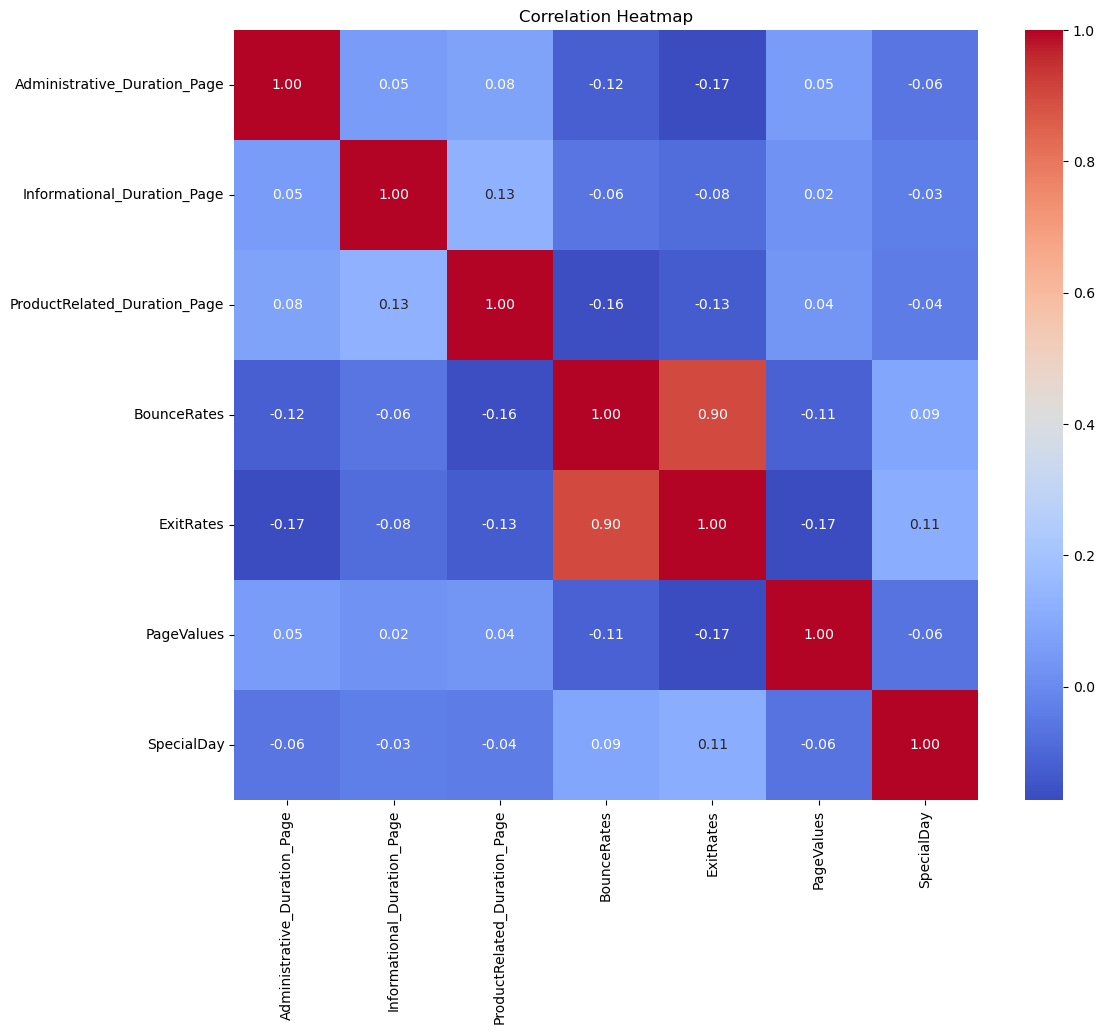

In [49]:
plt.figure(figsize=(12 , 10))
sns.heatmap(X_train[numerical_columns].corr(), cmap = 'coolwarm', annot = True, fmt = '.2f')
plt.title('Correlation Heatmap')

In [50]:
def ChiSquareContingency(data, y_train):
    p_value = chi2_contingency(pd.crosstab(data, y_train))[1]
    print(f'p-value: {p_value}')
    if p_value > 0.05:
        print(f'Accept H0, feature {data.name} is independent with Revenue')
    else:
        print(f'Reject H0, feature {data.name} is dependent with Revenue')

# Assuming you are iterating over categorical columns
for column in categorical_columns:
    ChiSquareContingency(X_train[column], y_train)
    print('')

p-value: 1.6351464585069558e-52
Reject H0, feature Month is dependent with Revenue

p-value: 1.0908594134349057e-08
Reject H0, feature OperatingSystems is dependent with Revenue

p-value: 0.007700184985415064
Reject H0, feature Browser is dependent with Revenue

p-value: 0.7276408547218776
Accept H0, feature Region is independent with Revenue

p-value: 1.7604246936686518e-42
Reject H0, feature TrafficType is dependent with Revenue

p-value: 2.3212741382161994e-21
Reject H0, feature VType_New_Visitor is dependent with Revenue

p-value: 0.9733241469555696
Accept H0, feature VType_Other is independent with Revenue

p-value: 8.81727274938809e-21
Reject H0, feature VType_Returning_Visitor is dependent with Revenue

p-value: 0.05252649771069415
Accept H0, feature Weekend is independent with Revenue



<Axes: ylabel='SpecialDay'>

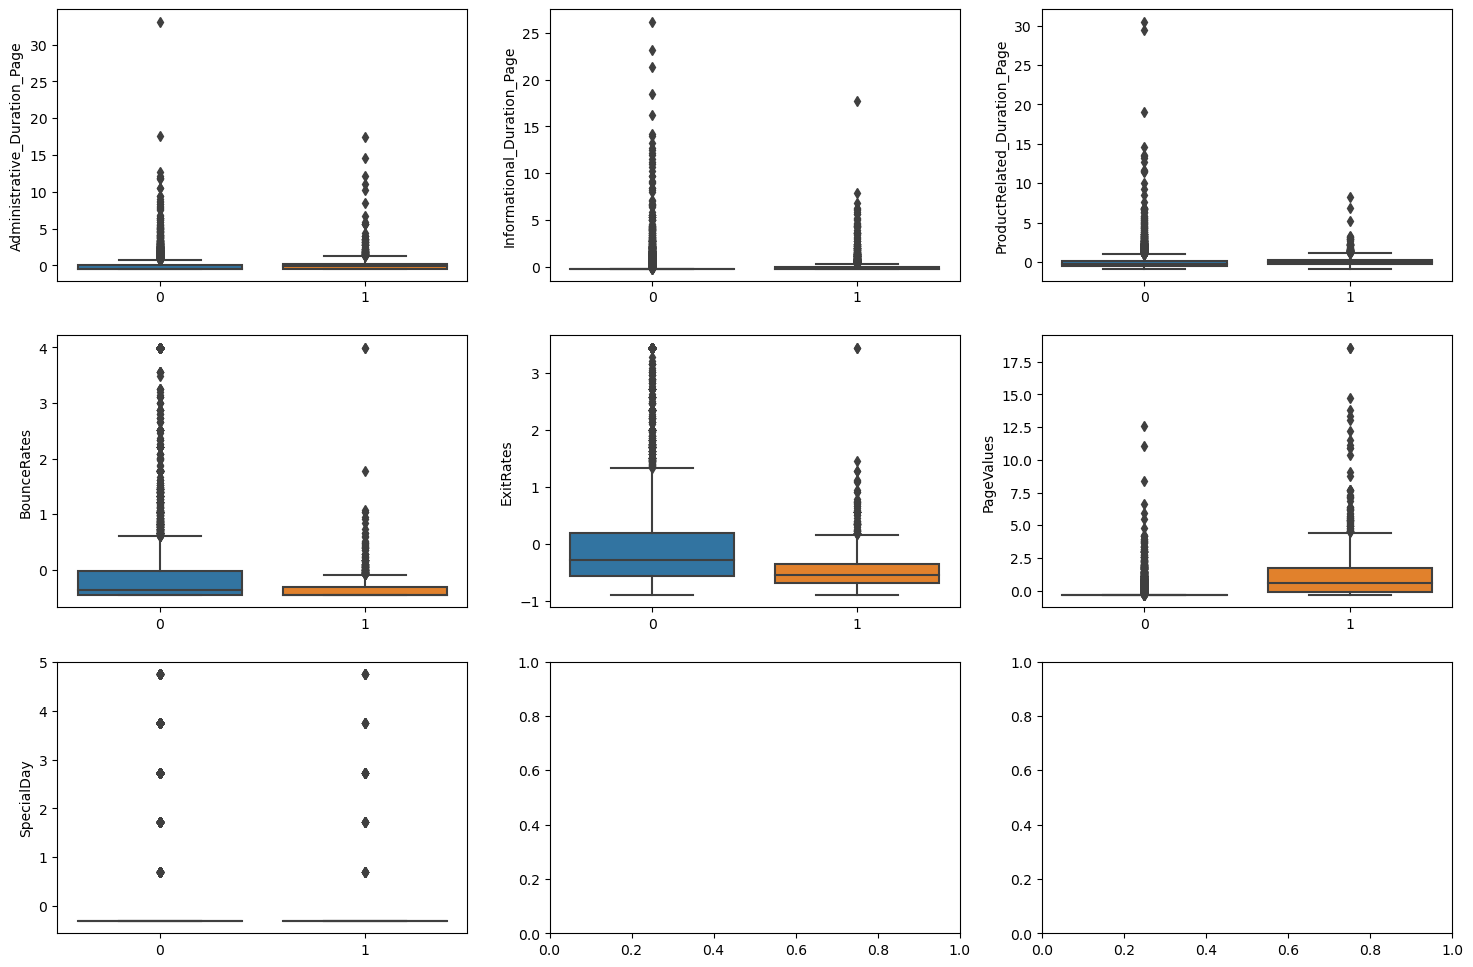

In [51]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))


sns.boxplot(ax=axes[0, 0], x=y_train, y=X_train['Administrative_Duration_Page'])
sns.boxplot(ax=axes[0, 1], x=y_train, y=X_train['Informational_Duration_Page'])
sns.boxplot(ax=axes[0, 2], x=y_train, y=X_train['ProductRelated_Duration_Page'])
sns.boxplot(ax=axes[1, 0], x=y_train, y=X_train['BounceRates'])
sns.boxplot(ax=axes[1, 1], x=y_train, y=X_train['ExitRates'])
sns.boxplot(ax=axes[1, 2], x=y_train, y=X_train['PageValues'])
sns.boxplot(ax=axes[2, 0], x=y_train, y=X_train['SpecialDay'])



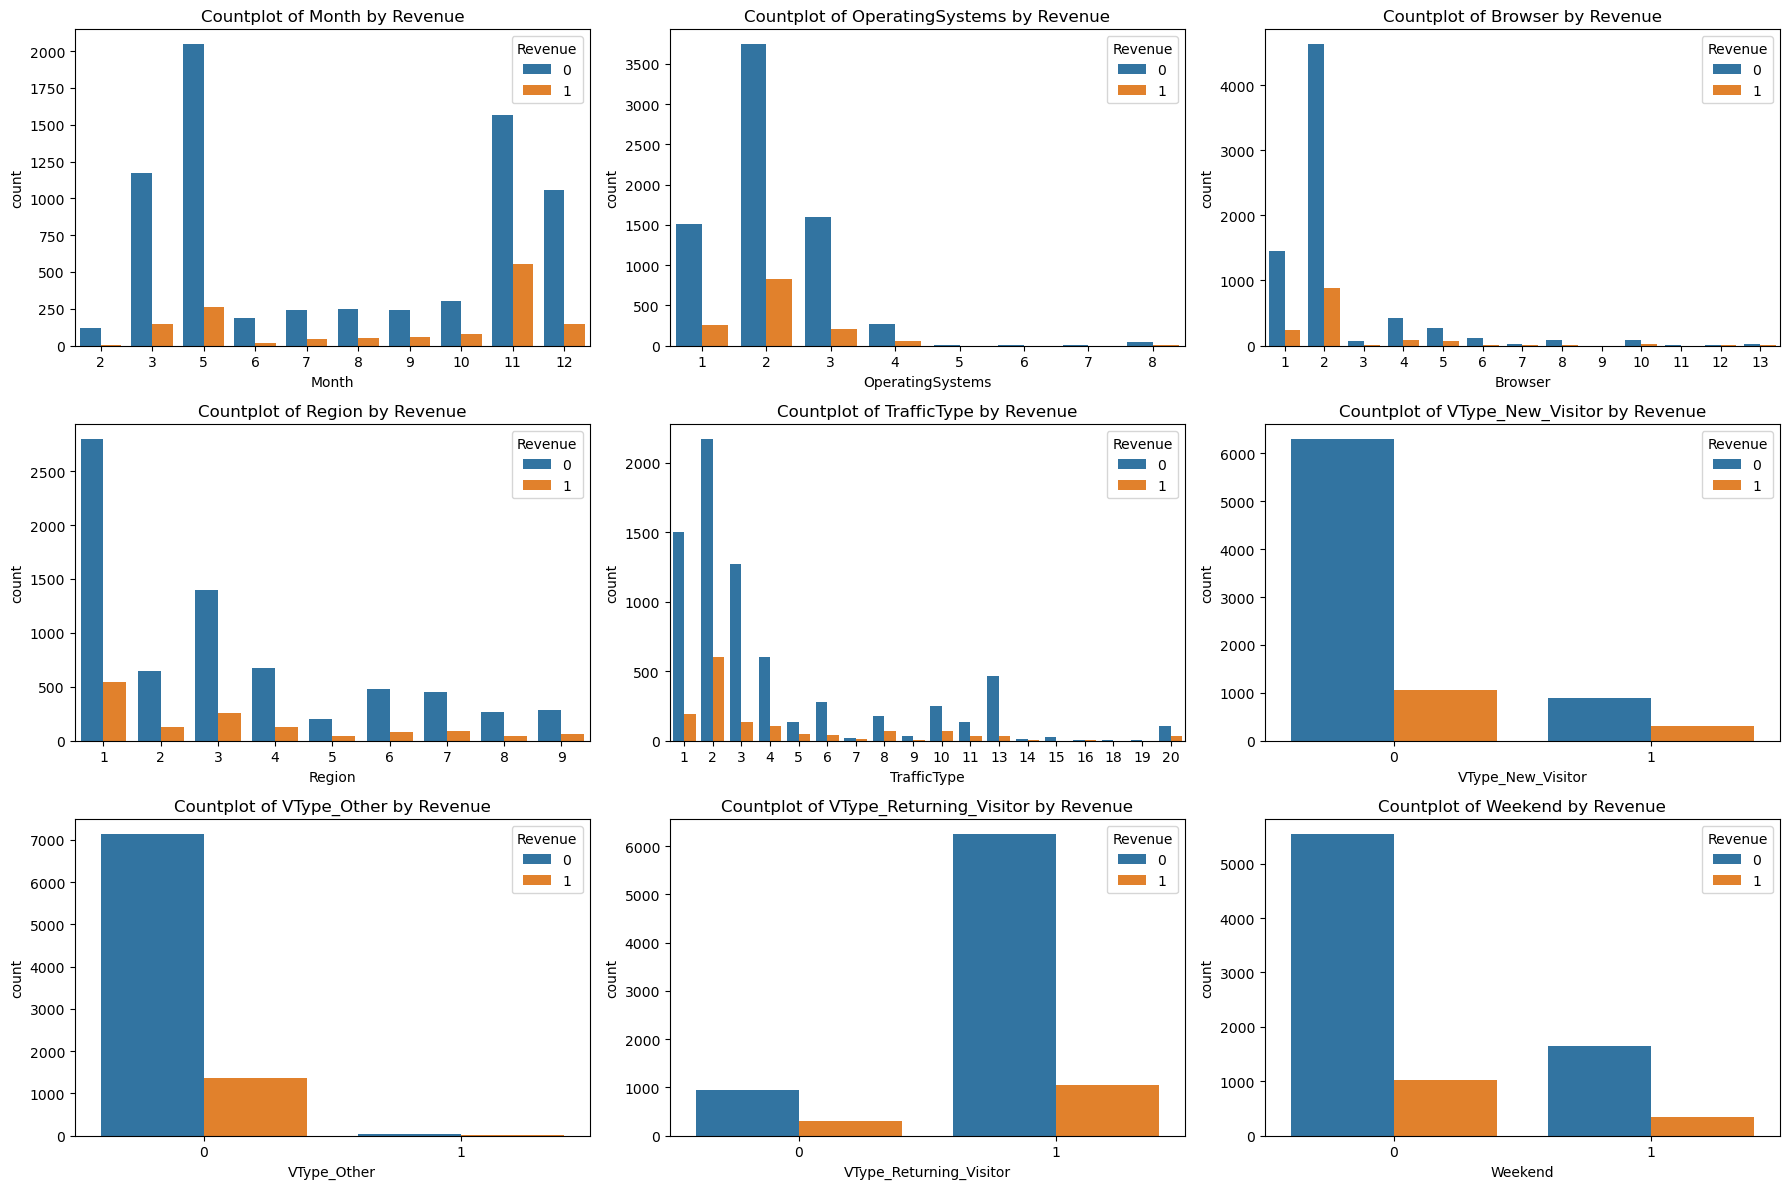

In [52]:
ig, axes = plt.subplots(3, 3, figsize=(18, 12))

# Flatten the axes array to easily iterate over subplots
axes = axes.flatten()

# Loop through each categorical column and create a countplot in each subplot
for i, column in enumerate(categorical_columns):
    sns.countplot(x=column, hue=y_train, data=X_train, ax=axes[i])
    axes[i].set_title(f'Countplot of {column} by Revenue')
    axes[i].legend(title='Revenue')
        

# Adjust layout to prevent overlap of subplots
plt.tight_layout()
plt.show()

# after SMOTE


Text(0.5, 1.0, 'Correlation Heatmap')

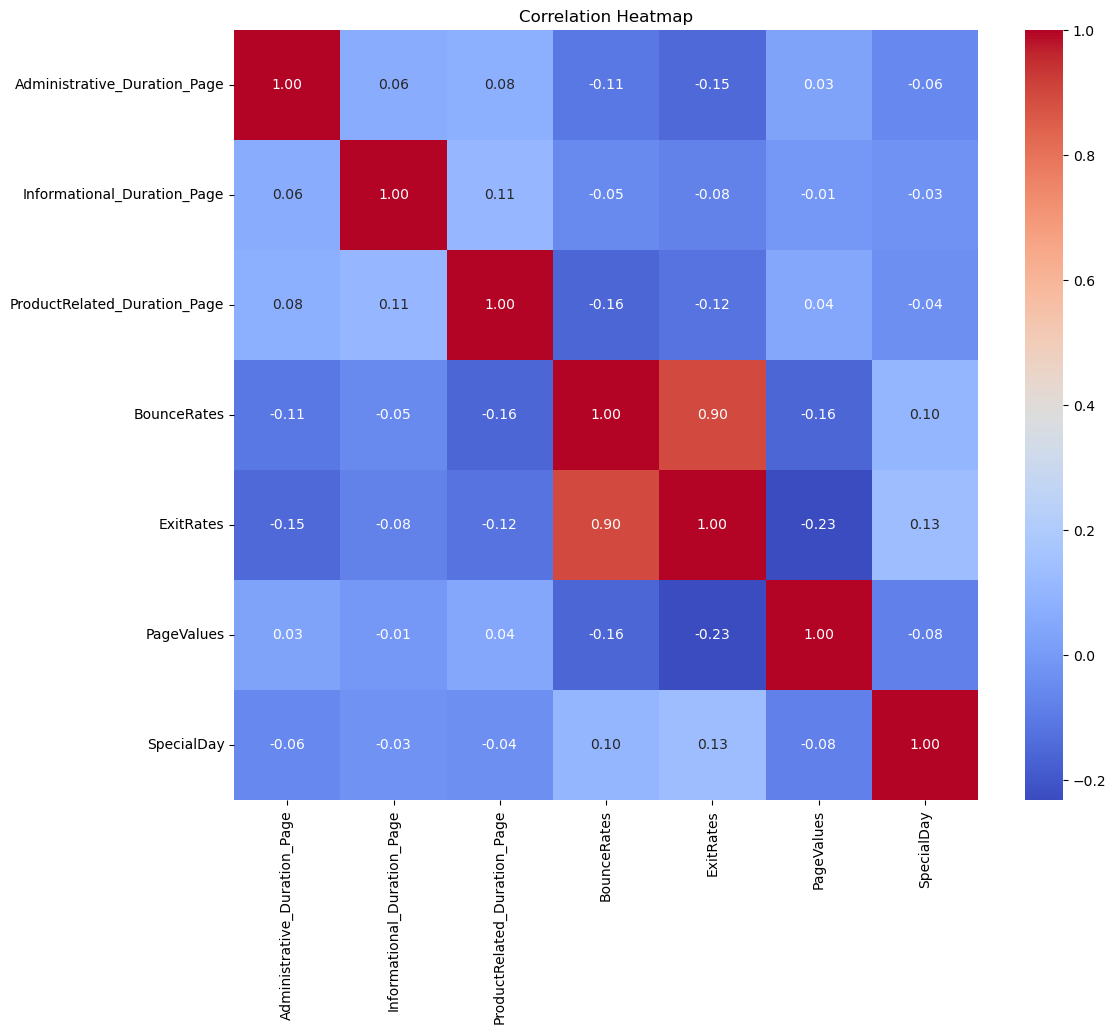

In [53]:
plt.figure(figsize=(12 , 10))
sns.heatmap(X_train_smote[numerical_columns].corr(), cmap = 'coolwarm', annot = True, fmt = '.2f')
plt.title('Correlation Heatmap')

In [54]:
def ChiSquareContingency(data, y_train):
    p_value = chi2_contingency(pd.crosstab(data, y_train))[1]
    print(f'p-value: {p_value}')
    if p_value > 0.05:
        print(f'Accept H0, feature {data.name} is independent with Revenue')
    else:
        print(f'Reject H0, feature {data.name} is dependent with Revenue')

# Assuming you are iterating over categorical columns
for column in categorical_columns:
    ChiSquareContingency(X_train_smote[column], y_train_smote)
    print('')

p-value: 5.303035575774066e-262
Reject H0, feature Month is dependent with Revenue

p-value: 2.567534961928342e-94
Reject H0, feature OperatingSystems is dependent with Revenue

p-value: 3.438937423079586e-15
Reject H0, feature Browser is dependent with Revenue

p-value: 3.312429831305457e-11
Reject H0, feature Region is dependent with Revenue

p-value: 5.630718650538669e-183
Reject H0, feature TrafficType is dependent with Revenue

p-value: 3.1625343647392484e-06
Reject H0, feature VType_New_Visitor is dependent with Revenue

p-value: 0.6009994971680879
Accept H0, feature VType_Other is independent with Revenue

p-value: 8.785050314912667e-98
Reject H0, feature VType_Returning_Visitor is dependent with Revenue

p-value: 3.2977895793687217e-43
Reject H0, feature Weekend is dependent with Revenue



<Axes: ylabel='SpecialDay'>

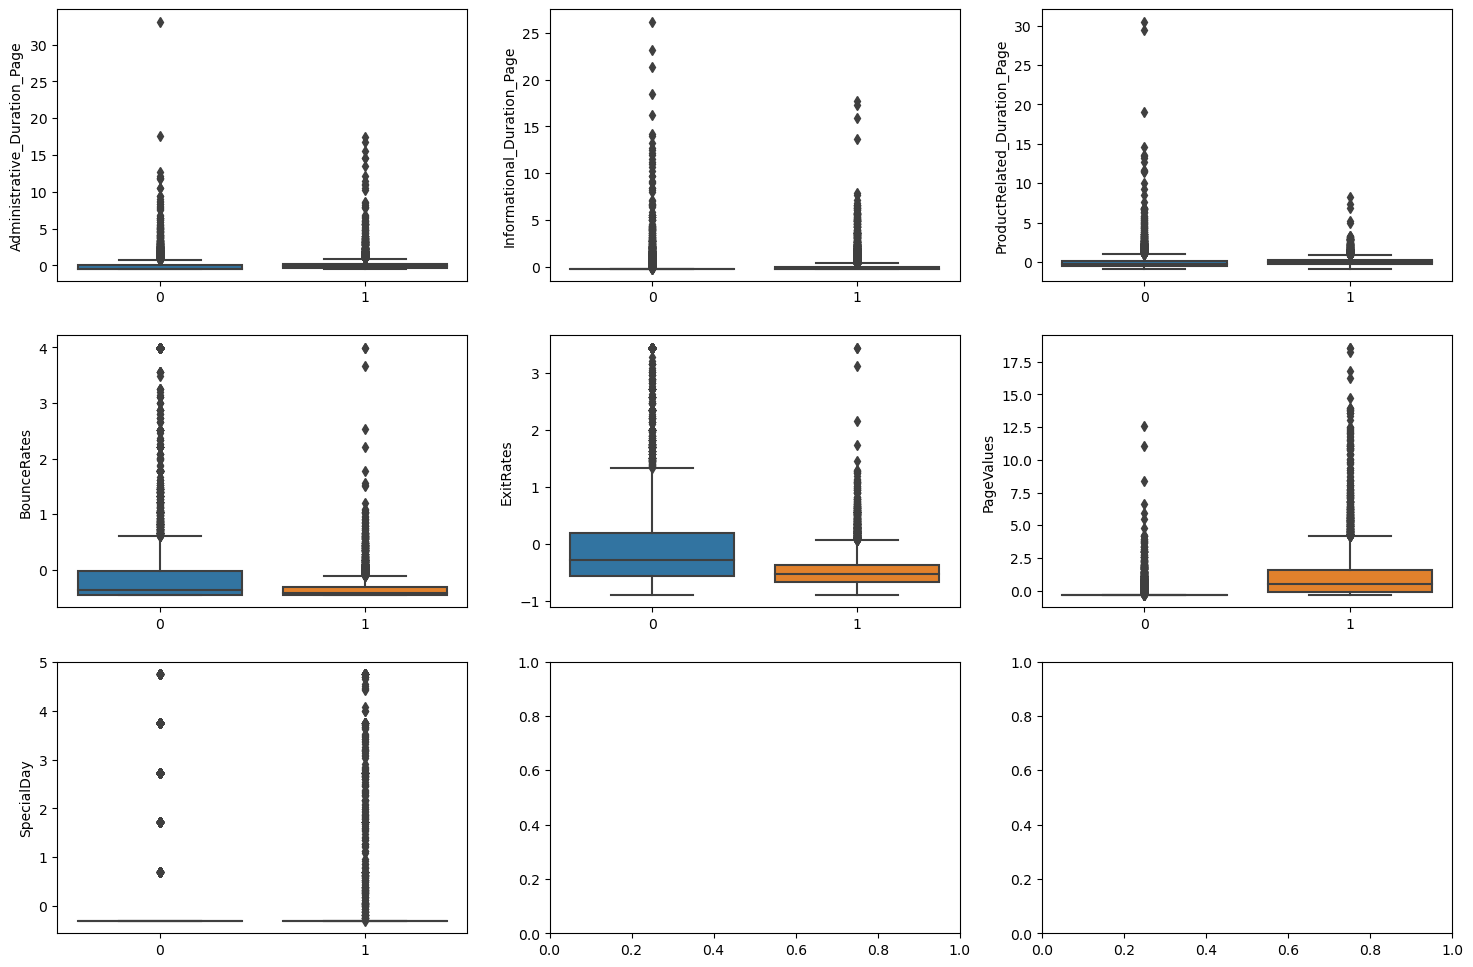

In [55]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))


sns.boxplot(ax=axes[0, 0], x=y_train_smote, y=X_train_smote['Administrative_Duration_Page'])
sns.boxplot(ax=axes[0, 1], x=y_train_smote, y=X_train_smote['Informational_Duration_Page'])
sns.boxplot(ax=axes[0, 2], x=y_train_smote, y=X_train_smote['ProductRelated_Duration_Page'])
sns.boxplot(ax=axes[1, 0], x=y_train_smote, y=X_train_smote['BounceRates'])
sns.boxplot(ax=axes[1, 1], x=y_train_smote, y=X_train_smote['ExitRates'])
sns.boxplot(ax=axes[1, 2], x=y_train_smote, y=X_train_smote['PageValues'])
sns.boxplot(ax=axes[2, 0], x=y_train_smote, y=X_train_smote['SpecialDay'])



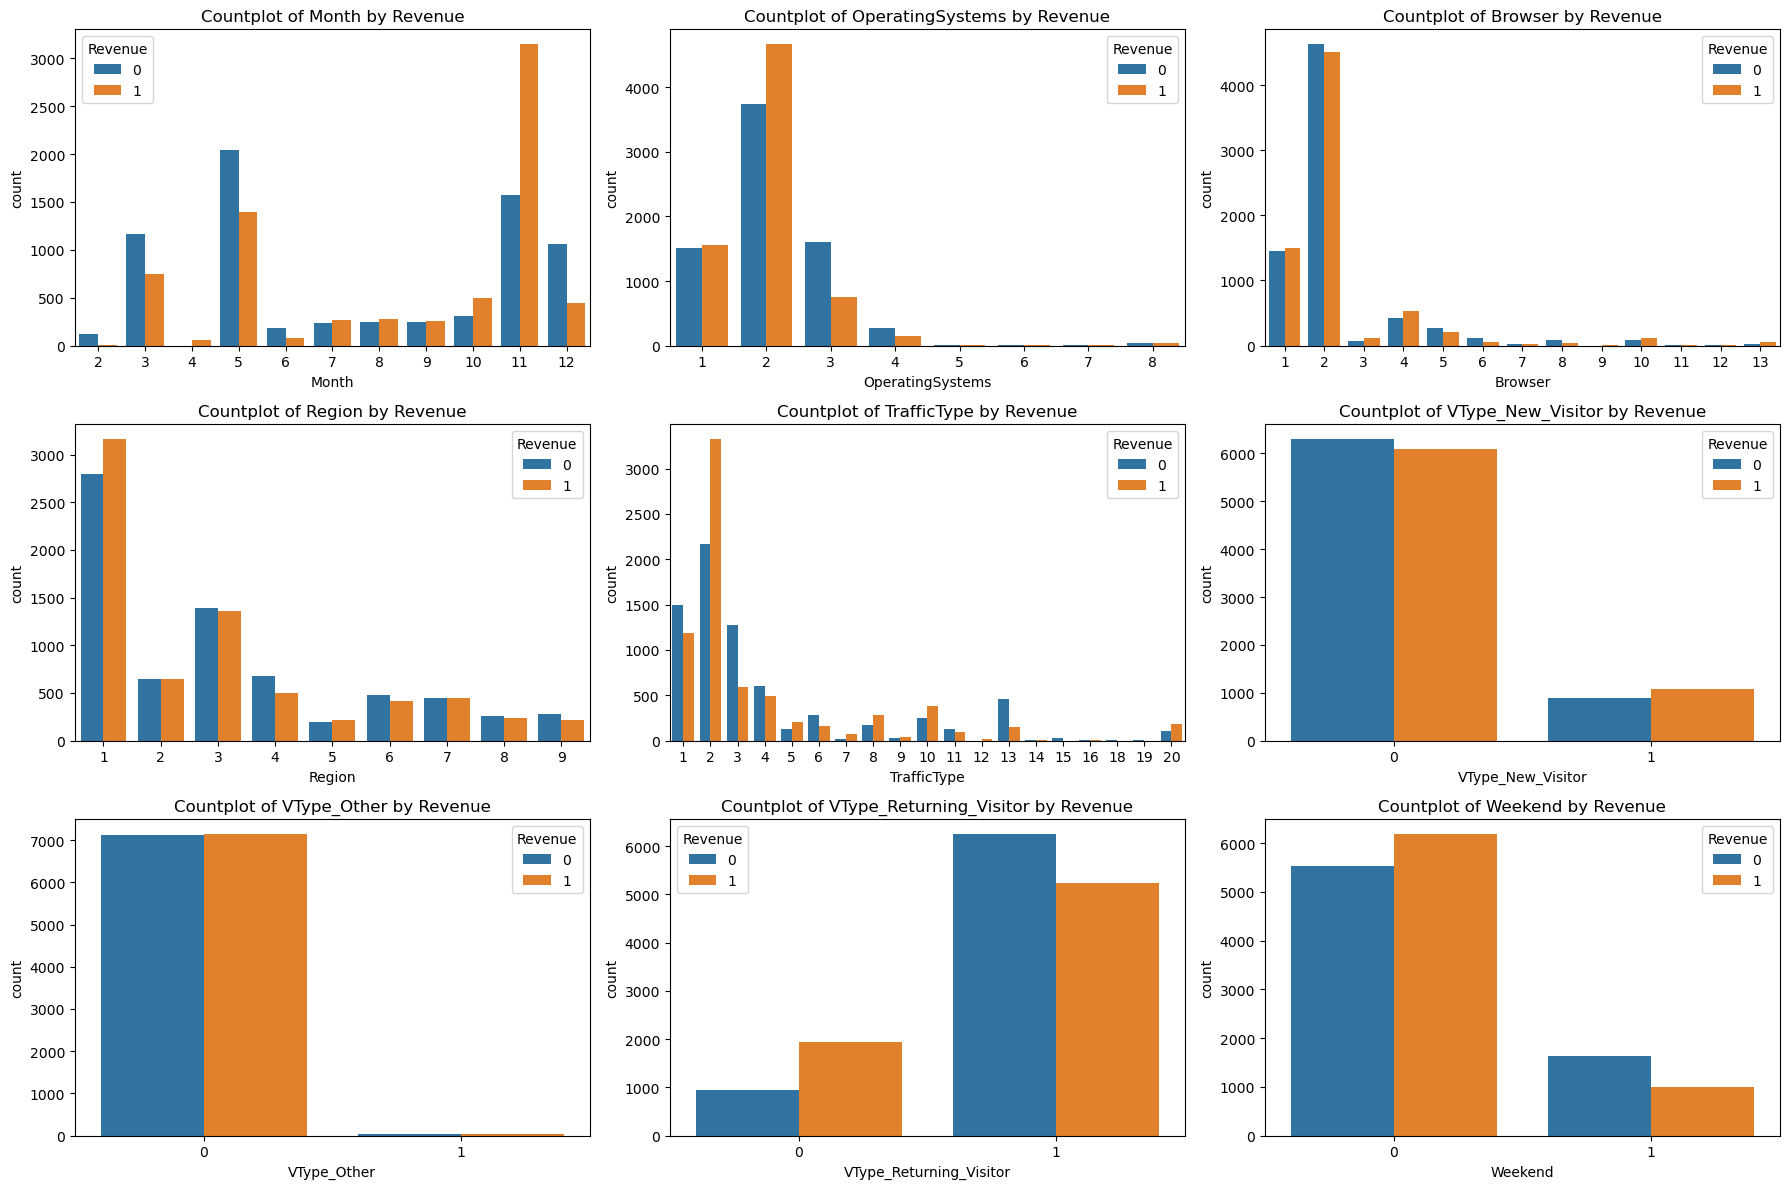

In [56]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

# Flatten the axes array to easily iterate over subplots
axes = axes.flatten()

# Loop through each categorical column and create a countplot in each subplot
for i, column in enumerate(categorical_columns):
    sns.countplot(x=column, hue=y_train_smote, data=X_train_smote, ax=axes[i])
    axes[i].set_title(f'Countplot of {column} by Revenue')
    axes[i].legend(title='Revenue')
    
    

# Adjust layout to prevent overlap of subplots
plt.tight_layout()
plt.show()

# FAMD

In [60]:
# from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
# chi_square_value,p_value=calculate_bartlett_sphericity(fa_df)

In [42]:
X1=X.copy()

In [43]:
X1

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False


In [44]:
X_= pipe1.fit_transform(X1.copy())

In [45]:
X_

,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Administrative_Duration_Page,Informational_Duration_Page,ProductRelated_Duration_Page
0,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,0.000000,0.0,0.000000
1,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,0.000000,0.0,32.000000
2,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,0.000000,0.0,0.000000
3,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,0.000000,0.0,1.333333
4,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,0.000000,0.0,62.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,48.333333,0.0,33.656447
12326,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,0.000000,0.0,93.150000
12327,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,0.000000,0.0,30.708333
12328,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,18.750000,0.0,23.066667


In [46]:
y1=y.copy()

In [47]:
y1=LabelEncoder().fit_transform(y1)

In [48]:
#true-1 false-0

X_['Weekend'] = LabelEncoder().fit_transform(X_['Weekend'])
     

# label encoding for Month
mapping_month = {'Jan' : 1, 'Feb' : 2,
                 'Mar' : 3, 'Apr' : 4,
                 'May' : 5, 'June' : 6,
                 'Jul' : 7, 'Aug' : 8,
                 'Sep' : 9, 'Oct' : 10,
                 'Nov' : 11, 'Dec' : 12}

X_['Month'] = X_['Month'].map(mapping_month)


In [50]:
X_.columns

Index(['BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Administrative_Duration_Page',
       'Informational_Duration_Page', 'ProductRelated_Duration_Page'],
      dtype='object')

In [51]:
one_hot_encoded_data =pd.get_dummies(X_['VisitorType'],prefix="VType")
X_ = X_.join(one_hot_encoded_data)
X_ = X_.drop(['VisitorType'], axis = 1)


In [52]:
X_['VType_New_Visitor'] = LabelEncoder().fit_transform(X_['VType_New_Visitor'])
X_['VType_Other'] = LabelEncoder().fit_transform(X_['VType_Other'])
X_['VType_Returning_Visitor'] = LabelEncoder().fit_transform(X_['VType_Returning_Visitor'])



In [55]:
X_

,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend,Administrative_Duration_Page,Informational_Duration_Page,ProductRelated_Duration_Page,VType_New_Visitor,VType_Other,VType_Returning_Visitor
0,0.200000,0.200000,0.000000,0.0,2,1,1,1,1,0,0.000000,0.0,0.000000,0,0,1
1,0.000000,0.100000,0.000000,0.0,2,2,2,1,2,0,0.000000,0.0,32.000000,0,0,1
2,0.200000,0.200000,0.000000,0.0,2,4,1,9,3,0,0.000000,0.0,0.000000,0,0,1
3,0.050000,0.140000,0.000000,0.0,2,3,2,2,4,0,0.000000,0.0,1.333333,0,0,1
4,0.020000,0.050000,0.000000,0.0,2,3,3,1,4,1,0.000000,0.0,62.750000,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,0.007143,0.029031,12.241717,0.0,12,4,6,1,1,1,48.333333,0.0,33.656447,0,0,1
12326,0.000000,0.021333,0.000000,0.0,11,3,2,1,8,1,0.000000,0.0,93.150000,0,0,1
12327,0.083333,0.086667,0.000000,0.0,11,3,2,1,13,1,0.000000,0.0,30.708333,0,0,1
12328,0.000000,0.021053,0.000000,0.0,11,2,2,3,11,0,18.750000,0.0,23.066667,0,0,1


In [58]:
X_numerical = X_[numerical_columns]
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)
X_[numerical_columns] = X_numerical_scaled


In [73]:
import prince
import pprint

In [96]:
# result=[]
# eigen=[]
# for n in np.arange(1,14):
#     famd = prince.FAMD(n_components=n,check_input=True,)
#     famd.fit(X_)
#     result.append(sum(famd.row_coordinates))
# ax=sns.barplot(np.arange(1,14),result)
# plt.title('Explained Variance of FAMD')
# plt.xlabel('Number of component')
# plt.ylabel('Explained Variance')
# ax.bar_label(ax.containers[0], labels=[f'{X_:.2f}' for X_ in ax.containers[0].datavalues])

In [97]:
famd = prince.FAMD(n_components=8,check_input=True,)
XX=famd.fit_transform(X_)
XX

component,0,1,2,3,4,5,6,7
0,-1.332402,0.976379,1.043203,7.514572,-1.308692,0.109135,-2.419166,-1.149950
1,-1.014059,1.199617,0.402954,0.487199,-1.764890,0.610491,-2.036005,1.036807
2,1.345067,1.524773,0.904391,7.120854,-2.105846,-0.793657,-5.720556,1.036999
3,-1.516124,3.061095,0.579440,0.810551,1.581160,-3.273346,-2.661703,-1.467758
4,-1.712068,1.850708,1.766374,1.074850,7.634015,-3.510819,-4.038766,-5.615897
...,...,...,...,...,...,...,...,...
12325,-0.133921,1.261915,0.145626,1.616114,-2.903383,1.351428,-2.682413,0.837835
12326,-0.331195,-1.491335,0.061430,-1.025809,4.962848,3.819757,-2.167853,1.132039
12327,-1.108332,2.449197,-0.492533,-1.418974,6.629250,0.240385,-2.115915,1.773717
12328,-0.722876,0.853364,0.506092,-1.094758,2.699749,0.161675,7.972311,0.896832


In [107]:
def algorithm(algo,name='cluster',x='None'):
    al = algo
    result=al.fit_predict(x)
    return result,al

In [108]:
def getCluster(dfCopy,clusters):
    df=dfCopy.copy()
    df['cluster']=clusters
    cluster_centers = df.groupby('cluster').mean()
    cluster_centers['cluster size'] = pd.Series(df['cluster']).value_counts() / len(df['cluster']) * 100
    return cluster_centers,df

In [109]:
def evaluateCluster(x,labels,algName='Undefined testing',record=pd.DataFrame({'name':[],'silihouette_score':[],'davies_bouldin_score':[]})):
    '''
    This function is used for model evaluation . 
    '''
    current=pd.DataFrame({'name':[algName],'silihouette_score':[silhouette_score(x,labels)],'davies_bouldin_score':[davies_bouldin_score(x,labels)],})
    record=pd.concat([record,current],ignore_index=True)
    display(skplt.metrics.plot_silhouette(x,labels))
    return current,record

In [110]:
X_.columns

Index(['BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend',
       'Administrative_Duration_Page', 'Informational_Duration_Page',
       'ProductRelated_Duration_Page', 'VType_New_Visitor', 'VType_Other',
       'VType_Returning_Visitor'],
      dtype='object')

In [111]:
X_cat=['Month','OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend','VType_New_Visitor', 'VType_Other',
       'VType_Returning_Visitor']

In [112]:
def qualitativeEvaluation(data):

    fig, ax = plt.subplots(int(np.ceil(len(X_cat)/2)), 2, figsize=(10, 12), tight_layout=True)
    for i,fea in enumerate(X_cat):
        n=1 if i%2==0 else 0

        (data.groupby('cluster')[fea].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.barplot,'data'), x='cluster',y='percent',hue=fea,ax=ax[int(np.floor(i/2)),n]))
    return fig.show()

In [114]:
from sklearn.cluster import SpectralClustering
def GridSearchForK(x=None,start=2,end=15,algorithm=SpectralClustering,**kwrg):
    x=x.copy()
    silhouette_avg = []
    davies_avg=[]
    rangeSearch=range(start,end)
    for num_clusters in rangeSearch:
 
     
        sci = algorithm(n_clusters=num_clusters,**kwrg)
        if (hasattr(algorithm(),'random_state')):
            sci = algorithm(n_clusters=num_clusters,random_state=42,**kwrg)
        sci.fit(x)
        cluster_labels = sci.labels_
 
    # silhouette score
        davies_avg.append(davies_bouldin_score(x, cluster_labels))
        silhouette_avg.append(silhouette_score(x, cluster_labels))
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,8))   
    ax1.plot(rangeSearch,silhouette_avg,'bx-',color='blue',label='Silhouette')
    ax1.set_title('Silhouette Score')
    ax2.plot(rangeSearch,davies_avg,'bx-',color='red',label='Davies Bouldin')
    ax2.set_title('Davies Bouldin Score')
    plt.xlabel('Values of K') 
    return fig.show()

In [117]:
pip install scikit-learn-extra

  Obtaining dependency information for scikit-learn-extra from https://files.pythonhosted.org/packages/22/2f/86f58cb2bd3f81bdb28555470761c27c0d62a566329aac70e8507cb744fd/scikit_learn_extra-0.3.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/340.5 kB ? eta -:--:--
   - -------------------------------------- 10.2/340.5 kB ? eta -:--:--
   - -------------------------------------- 10.2/340.5 kB ? eta -:--:--
   --- ----------------------------------- 30.7/340.5 kB 262.6 kB/s eta 0:00:02
   --- ----------------------------------- 30.7/340.5 kB 262.6 kB/s eta 0:00:02
   ---- ---------------------------------- 41.0/340.5 kB 179.6 kB/s eta 0:00:02
   -------- ------------------------------ 71.7/340.5 kB 245.8 kB/s eta 0:00:02
   ------------ ------------------------- 112.6/340.5 kB 345.9 kB/s eta 0:00:01
   ------------- ------------------------ 122.9/340.5 kB 328.4 kB/s eta 0:00:01
   ------------------- ------------------ 174.1/340.5 kB 403.5 kB/s eta 0:0

In [120]:
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score



GridSearchForK(X_,2,15,KMedoids,method='pam')

KeyboardInterrupt: 

In [ ]:

result,kme=algorithm(KMedoids(n_clusters=4,method='pam'),'cluster',x_train)
evaluation,kmeDf=getCluster(emDf,result)
evaluation

In [ ]:
qualitativeEvaluation(kmeDf)

In [ ]:
kmeDf.groupby('cluster')['Resign Status'].describe()

In [ ]:
sns.scatterplot(pd.DataFrame(x_train)[0],pd.DataFrame(x_train)[1],hue=kmeDf.cluster, palette="tab10")

In [302]:
# clustering


In [292]:
# import prince
# import pprint

In [293]:
# famd = prince.FAMD(
#     n_components=5,
#     n_iter=10,
#     copy=True,
#     check_input=True,
#     engine='sklearn', 
#     random_state=42)

In [294]:
# famd = famd.fit(X_train_smote)

In [295]:
# famd.row_coordinates(X_train_smote)

In [296]:
# ax = famd.plot_row_coordinates(
# ...     X_train_smote,
# ...     ax=None,
# ...     figsize=(6, 6),
# ...     x_component=0,
# ...     y_component=1,
# ...     labels=X.index,
# ...     #color_labels=['Oak type {}'.format(t) for t in X['Oak type']],
# ...     ellipse_outline=False,
# ...     ellipse_fill=True,
# ...     show_points=True
# ... )

In [297]:
# famd.eigenvalues_summary

In [298]:
# famd.row_coordinates(X_train_smote).head()

In [299]:
# famd.plot(
#     X_train_smote,
#     x_component=0,
#     y_component=1
# )

In [300]:
# from sklearn.cluster import KMeans
# cs = []
# for i in range(1, 11):
#     kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
#     kmeans.fit(X_train)
#     labels=kmeans.labels_
#     cs.append(kmeans.inertia_)
# plt.plot(range(1, 11), cs)
# plt.grid()
# plt.title('The Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('CS')
# plt.show()

In [301]:
# km = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
# y_means = km.fit_predict(X_train)
# y_means


# advanced analysis


### Logistic Regression


In [158]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
import shap

In [159]:
def eval_(model):
    y_pred=model.predict(X_test)
    y_pred_train=model.predict(X_train_smote)
    
    print("Accuracy Score(Train set): %.2f" % accuracy_score(y_train_smote, y_pred_train))
    print("Accuracy Score(Test set): %.2f" % accuracy_score(y_test, y_pred))
    
    print("Precision Score (Train set):%.2f" % precision_score(y_train_smote, y_pred_train))
    print("Precision Score (Test set):%.2f" % precision_score(y_test, y_pred))

    print("Recall Score (Train set):%.2f" % recall_score(y_train_smote, y_pred_train))
    print("Recall Score (Test set):%.2f" % recall_score(y_test, y_pred))

    print("F1 Score (Train set):%.2f" % f1_score(y_train_smote, y_pred_train))
    print("F1 Score (Test set):%.2f" % f1_score(y_test, y_pred))
    
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train_smote)
    
    print("ROC AUC Score (Train-proba): %.2f" % roc_auc_score (y_train_smote, y_pred_proba_train[:,1]))
    print("ROC AUC Score (Test-proba): %.2f" % roc_auc_score (y_test, y_pred_proba[:,1]))
    
    print('Confusion Matrix:\n ', confusion_matrix(y_train_smote, y_pred_train))

In [160]:
logModel=LogisticRegression()
logModel.fit(X_train_smote,y_train_smote)

LogisticRegression()

In [161]:
eval_(logModel)

Accuracy Score(Train set): 0.82
Accuracy Score(Test set): 0.83
Precision Score (Train set):0.84
Precision Score (Test set):0.46
Recall Score (Train set):0.80
Recall Score (Test set):0.78
F1 Score (Train set):0.82
F1 Score (Test set):0.58
ROC AUC Score (Train-proba): 0.91
ROC AUC Score (Test-proba): 0.89
Confusion Matrix:
  [[6073 1109]
 [1434 5748]]


#### Logistic regression - hyperparameter tuning

In [162]:
logModel.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [163]:
param_grid={'solver':['sag','saga','newton-cholesky'],
         'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
         'C':np.linspace(0.001, 0.2, 20),
         'max_iter' : [100, 300,500, 1000]}

In [164]:
logModel1=LogisticRegression()

In [165]:
log_grid = GridSearchCV(logModel1, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

In [166]:
score=log_grid.fit(X_train_smote,y_train_smote)

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


In [167]:
score.best_params_


{'C': 0.021947368421052632, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}

In [168]:
best_log_grid=score.best_estimator_

In [169]:
eval_(best_log_grid)

Accuracy Score(Train set): 0.82
Accuracy Score(Test set): 0.83
Precision Score (Train set):0.84
Precision Score (Test set):0.47
Recall Score (Train set):0.79
Recall Score (Test set):0.77
F1 Score (Train set):0.82
F1 Score (Test set):0.58
ROC AUC Score (Train-proba): 0.91
ROC AUC Score (Test-proba): 0.89
Confusion Matrix:
  [[6113 1069]
 [1477 5705]]


<Axes: ylabel='Feature'>

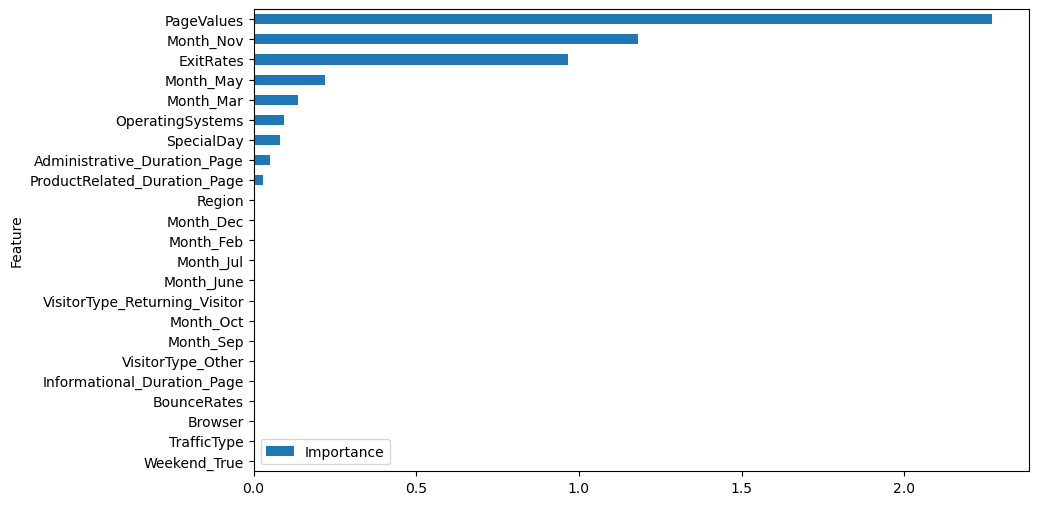

In [170]:
coefficients = best_log_grid.coef_

avg_importance = np.mean(np.abs(coefficients), axis=0)
feature_importance = pd.DataFrame({'Feature': X_train_smote.columns, 'Importance': avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

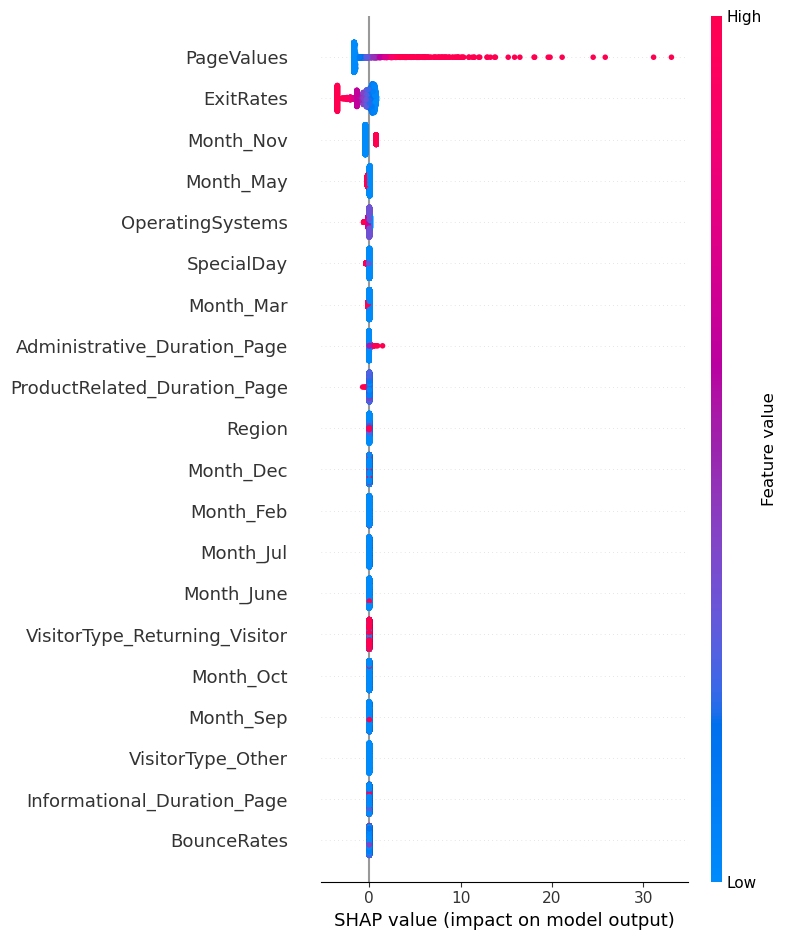

In [171]:
explainer = shap.LinearExplainer(best_log_grid, X_train_smote)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


## KNN

In [172]:
from sklearn.neighbors import KNeighborsClassifier

In [173]:
knn = KNeighborsClassifier()
knn.fit(X_train_smote, y_train_smote)
eval_(knn)

Accuracy Score(Train set): 0.93
Accuracy Score(Test set): 0.78
Precision Score (Train set):0.87
Precision Score (Test set):0.38
Recall Score (Train set):0.99
Recall Score (Test set):0.68
F1 Score (Train set):0.93
F1 Score (Test set):0.48
ROC AUC Score (Train-proba): 0.99
ROC AUC Score (Test-proba): 0.80
Confusion Matrix:
  [[6147 1035]
 [  42 7140]]


In [174]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

#### KNN-hyperparameter tuning

In [210]:
param_grid={'n_neighbors': [5,10,50,100],
            'p' : [1,2],
            'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
           }

In [211]:
knn1=KNeighborsClassifier()

In [214]:
knn_grid = GridSearchCV(knn1, param_grid = param_grid, cv = 3,scoring='roc_auc')

In [215]:
score=knn_grid.fit(X_train_smote,y_train_smote)

In [216]:
score.best_params_

{'algorithm': 'auto', 'n_neighbors': 5, 'p': 1}

In [217]:
best_knn_grid=score.best_estimator_

In [218]:
eval_(best_knn_grid)

Accuracy Score(Train set): 0.95
Accuracy Score(Test set): 0.81
Precision Score (Train set):0.91
Precision Score (Test set):0.42
Recall Score (Train set):0.99
Recall Score (Test set):0.62
F1 Score (Train set):0.95
F1 Score (Test set):0.50
ROC AUC Score (Train-proba): 1.00
ROC AUC Score (Test-proba): 0.81
Confusion Matrix:
  [[6455  727]
 [  55 7127]]


In [316]:
#eval(best_knn_grid)
# Accuracy Score(Train set): 0.89
# Accuracy Score(Test set): 0.80
# Precision Score (Train set):0.60
# Precision Score (Test set):0.40
# Recall Score (Train set):0.96
# Recall Score (Test set):0.67
# F1 Score (Train set):0.74
# F1 Score (Test set):0.50
# ROC AUC Score (Train-proba): 0.98
# ROC AUC Score (Test-proba): 0.81
# Confusion Matrix:
#   [[6304  877]
#  [  48 1314]]

In [291]:
# f = lambda x: best_knn_grid.predict_proba(x)[:, 1]
# med = X_train_smote.median().values.reshape((1, X_train_smote.shape[1]))

# explainer = shap.Explainer(f, med)
# shap_values = explainer(X_test.iloc[0:1000, :])
# shap.plots.beeswarm(shap_values)

## Random forest

In [219]:
from sklearn.ensemble import RandomForestClassifier

In [220]:
rf = RandomForestClassifier()
rf.fit(X_train_smote, y_train_smote)
eval_(rf)

Accuracy Score(Train set): 1.00
Accuracy Score(Test set): 0.86
Precision Score (Train set):1.00
Precision Score (Test set):0.52
Recall Score (Train set):1.00
Recall Score (Test set):0.78
F1 Score (Train set):1.00
F1 Score (Test set):0.63
ROC AUC Score (Train-proba): 1.00
ROC AUC Score (Test-proba): 0.90
Confusion Matrix:
  [[7182    0]
 [   1 7181]]


In [221]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### Random Forest- Hyperparameter tuning

In [222]:
rf_param_grid = {'n_estimators': [50,100,150], 
                  'criterion': ['gini', 'entropy'],
                  'max_features': ['None','sqrt', 'log2'],
                  'max_depth' :[5,6,10],
#                   'min_samples_split': [2,10],
                  'min_samples_leaf' : [7,10] ,} 

In [223]:
rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, param_grid = rf_param_grid, cv = 3,scoring='roc_auc')

In [224]:
score=rf_grid.fit(X_train_smote,y_train_smote)

In [225]:
score.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 7,
 'n_estimators': 100}

In [226]:
best_rf_grid=score.best_estimator_

In [227]:
eval_(best_rf_grid)

Accuracy Score(Train set): 0.91
Accuracy Score(Test set): 0.85
Precision Score (Train set):0.90
Precision Score (Test set):0.51
Recall Score (Train set):0.93
Recall Score (Test set):0.84
F1 Score (Train set):0.92
F1 Score (Test set):0.63
ROC AUC Score (Train-proba): 0.98
ROC AUC Score (Test-proba): 0.91
Confusion Matrix:
  [[6462  720]
 [ 515 6667]]


In [228]:
# eval(best_rf_grid)

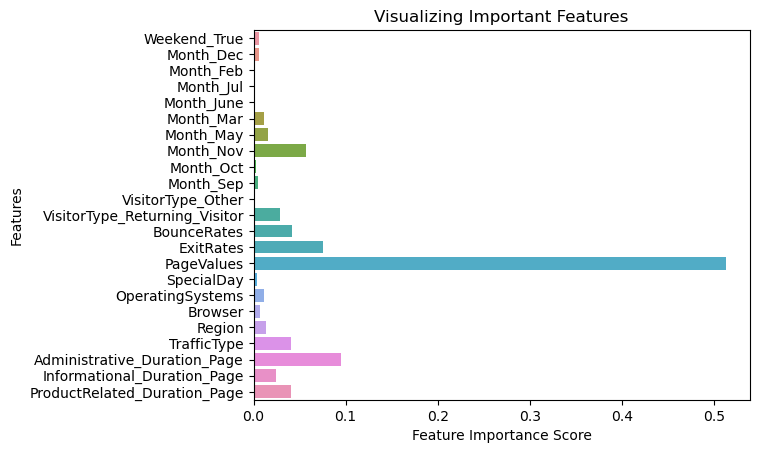

In [229]:
feature_imp1 = best_rf_grid.feature_importances_

sns.barplot(x=feature_imp1, y=X_test.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

## Decision tree

In [230]:
from sklearn.tree import DecisionTreeClassifier

In [231]:
dt = DecisionTreeClassifier()
dt.fit(X_train_smote, y_train_smote)
eval_(dt)

Accuracy Score(Train set): 1.00
Accuracy Score(Test set): 0.80
Precision Score (Train set):1.00
Precision Score (Test set):0.40
Recall Score (Train set):1.00
Recall Score (Test set):0.72
F1 Score (Train set):1.00
F1 Score (Test set):0.52
ROC AUC Score (Train-proba): 1.00
ROC AUC Score (Test-proba): 0.77
Confusion Matrix:
  [[7182    0]
 [   0 7182]]


#### Decision tree-Hyperparameter tuning

In [232]:
dt_param_grid={
    'max_depth' :[5,6,10],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [2, 7] ,
    'max_features' : ['auto', 'sqrt'],
    'criterion' : ['gini', 'entropy'],
    'splitter' : ['best', 'random']
}

In [233]:
dt = DecisionTreeClassifier(random_state = 42)
dt_grid = GridSearchCV(dt, param_grid = dt_param_grid, cv = 3,scoring='roc_auc')

In [234]:
score=dt_grid.fit(X_train_smote,y_train_smote)

In [235]:
score.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'splitter': 'best'}

In [236]:
best_dt_grid=score.best_estimator_

In [237]:
eval_(best_dt_grid)

Accuracy Score(Train set): 0.90
Accuracy Score(Test set): 0.81
Precision Score (Train set):0.90
Precision Score (Test set):0.43
Recall Score (Train set):0.90
Recall Score (Test set):0.76
F1 Score (Train set):0.90
F1 Score (Test set):0.54
ROC AUC Score (Train-proba): 0.96
ROC AUC Score (Test-proba): 0.87
Confusion Matrix:
  [[6432  750]
 [ 731 6451]]


In [238]:
#eval(best_dt_grid)

## AdaBoost

In [239]:
from sklearn.ensemble import AdaBoostClassifier

In [240]:
ab = AdaBoostClassifier()
ab.fit(X_train_smote, y_train_smote)
eval_(ab)

Accuracy Score(Train set): 0.90
Accuracy Score(Test set): 0.77
Precision Score (Train set):0.90
Precision Score (Test set):0.38
Recall Score (Train set):0.90
Recall Score (Test set):0.87
F1 Score (Train set):0.90
F1 Score (Test set):0.53
ROC AUC Score (Train-proba): 0.97
ROC AUC Score (Test-proba): 0.88
Confusion Matrix:
  [[6470  712]
 [ 684 6498]]


In [241]:
ab.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

#### AdaBoost - Hyperparameter Tuning -without base estimator

In [249]:
ab_param_grid={
    'algorithm': ['SAMME.R'],
    'learning_rate':[0.001,0.1,1],
    'n_estimators':[50,100,200],   
}

In [250]:
ab = AdaBoostClassifier(random_state=42)
ab_grid = GridSearchCV(ab, param_grid = ab_param_grid, cv = 3,scoring='roc_auc')

In [251]:
score=ab_grid.fit(X_train_smote,y_train_smote)

In [252]:
score.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 200}

In [253]:
best_ab_grid=score.best_estimator_

In [254]:
eval_(best_ab_grid)

Accuracy Score(Train set): 0.92
Accuracy Score(Test set): 0.63
Precision Score (Train set):0.92
Precision Score (Test set):0.28
Recall Score (Train set):0.92
Recall Score (Test set):0.93
F1 Score (Train set):0.92
F1 Score (Test set):0.43
ROC AUC Score (Train-proba): 0.98
ROC AUC Score (Test-proba): 0.85
Confusion Matrix:
  [[6575  607]
 [ 606 6576]]


In [255]:
#eval(best_ab_grid)

#### AdaBoost - Hyperparameter Tuning -with base estimator

In [323]:
ab_param_grid={
    'algorithm': ['SAMME.R'],
    'learning_rate':[0.001,0.1,1],
    'n_estimators':[50,100,200]
}

In [334]:
dt_ada = DecisionTreeClassifier(random_state = 42,max_depth=6)
ab = AdaBoostClassifier(random_state=42,estimator=dt_ada)
ab_grid = GridSearchCV(ab, param_grid = ab_param_grid, cv = 3,scoring='roc_auc')

In [335]:
score=ab_grid.fit(X_train_smote,y_train_smote)

In [336]:
score.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 200}

In [337]:
best_ab_grid=score.best_estimator_

In [338]:
eval_(best_ab_grid)

Accuracy Score(Train set): 1.00
Accuracy Score(Test set): 0.64
Precision Score (Train set):1.00
Precision Score (Test set):0.28
Recall Score (Train set):1.00
Recall Score (Test set):0.90
F1 Score (Train set):1.00
F1 Score (Test set):0.43
ROC AUC Score (Train-proba): 1.00
ROC AUC Score (Test-proba): 0.85
Confusion Matrix:
  [[7182    0]
 [   0 7182]]


## Gradient Boosting


In [264]:
from sklearn.ensemble import GradientBoostingClassifier

In [265]:
gb = GradientBoostingClassifier()
gb.fit(X_train_smote, y_train_smote)
eval_(gb)

Accuracy Score(Train set): 0.92
Accuracy Score(Test set): 0.62
Precision Score (Train set):0.92
Precision Score (Test set):0.28
Recall Score (Train set):0.93
Recall Score (Test set):0.95
F1 Score (Train set):0.92
F1 Score (Test set):0.43
ROC AUC Score (Train-proba): 0.98
ROC AUC Score (Test-proba): 0.87
Confusion Matrix:
  [[6587  595]
 [ 501 6681]]


#### Gradient Boosting - Hyperparameter Tuning

In [272]:
gb_param_grid={
    'n_estimators':[50,100,150],
    'max_depth':[4,5,6],
    'max_features':['log2','sqrt',None],
    #'min_samples_leaf': [2],
    'learning_rate':[0.001,0.1,1],
    'subsample':[0.5,0.6]
    
}

In [273]:
gb= GradientBoostingClassifier(random_state=42)
gb_grid = GridSearchCV(gb, param_grid = gb_param_grid, cv = 3,scoring='roc_auc')

In [274]:
score=gb_grid.fit(X_train_smote,y_train_smote)

In [276]:
score.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'max_features': None,
 'n_estimators': 150,
 'subsample': 0.6}

In [277]:
best_gb_grid=score.best_estimator_

In [278]:
eval_(best_gb_grid)

Accuracy Score(Train set): 0.97
Accuracy Score(Test set): 0.67
Precision Score (Train set):0.97
Precision Score (Test set):0.31
Recall Score (Train set):0.97
Recall Score (Test set):0.92
F1 Score (Train set):0.97
F1 Score (Test set):0.46
ROC AUC Score (Train-proba): 1.00
ROC AUC Score (Test-proba): 0.87
Confusion Matrix:
  [[6995  187]
 [ 186 6996]]


In [315]:
# eval(best_gb_grid)

## XGBoost 

In [279]:
from xgboost import XGBClassifier

In [280]:
xgb = XGBClassifier()
xgb.fit(X_train_smote, y_train_smote)
eval_(xgb)

Accuracy Score(Train set): 0.99
Accuracy Score(Test set): 0.69
Precision Score (Train set):0.99
Precision Score (Test set):0.32
Recall Score (Train set):0.99
Recall Score (Test set):0.93
F1 Score (Train set):0.99
F1 Score (Test set):0.47
ROC AUC Score (Train-proba): 1.00
ROC AUC Score (Test-proba): 0.86
Confusion Matrix:
  [[7104   78]
 [ 104 7078]]


#### XGBoost - Hyperparameter Tuning

In [308]:
xgb_param_grid={
    'max_depth':[4,5,6],
    'n_estimators':[100,200,300],
    'colsample_bytree':[0.1,0.5,1],
    'learning_rate':[0.001,0.1,1],
    'subsample':[0.5,0.6]
    
}

In [309]:
xgb= XGBClassifier(random_state=42)
xgb_grid = GridSearchCV(xgb, param_grid = xgb_param_grid, cv = 3,scoring='roc_auc')

In [310]:
score=xgb_grid.fit(X_train_smote,y_train_smote)

In [311]:
score.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 6,
 'n_estimators': 300,
 'subsample': 0.6}

In [312]:
best_xgb_grid=score.best_estimator_

In [313]:
eval_(best_gb_grid)

Accuracy Score(Train set): 0.97
Accuracy Score(Test set): 0.67
Precision Score (Train set):0.97
Precision Score (Test set):0.31
Recall Score (Train set):0.97
Recall Score (Test set):0.92
F1 Score (Train set):0.97
F1 Score (Test set):0.46
ROC AUC Score (Train-proba): 1.00
ROC AUC Score (Test-proba): 0.87
Confusion Matrix:
  [[6995  187]
 [ 186 6996]]


In [314]:
# eval(best_xgb_grid)

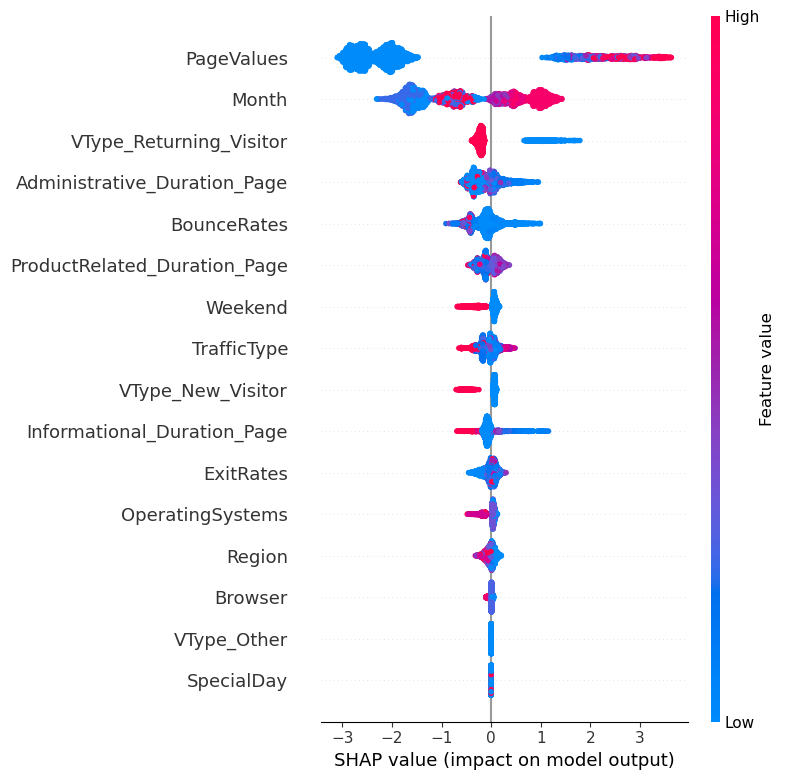

In [116]:
explainer = shap.TreeExplainer(best_xgb_grid)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

## SVM

In [85]:
from sklearn.svm import SVC

In [86]:
svc = SVC(probability=False)
svc.fit(X_train_smote, y_train_smote)
eval_(svc)

Accuracy Score(Train set): 0.85
Accuracy Score(Test set): 0.88
Precision Score (Train set):0.90
Precision Score (Test set):0.59
Recall Score (Train set):0.77
Recall Score (Test set):0.71
F1 Score (Train set):0.83
F1 Score (Test set):0.65


AttributeError: predict_proba is not available when  probability=False

In [93]:
svc_param_grid = {'C': [0.1, 1,10,100], 
              'gamma': [0.1,0.01,0.001], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']} 

In [94]:
svc= SVC()
svc_grid = GridSearchCV(svc, param_grid = svc_param_grid, cv = 3,scoring='roc_auc')

In [ ]:
score=svc_grid.fit(X_train_smote,y_train_smote)

In [90]:
score.best_params_

{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

In [91]:
best_svc_grid=score.best_estimator_

In [92]:
eval_(best_svc_grid)

Accuracy Score(Train set): 0.89
Accuracy Score(Test set): 0.85
Precision Score (Train set):0.88
Precision Score (Test set):0.49
Recall Score (Train set):0.91
Recall Score (Test set):0.74
F1 Score (Train set):0.89
F1 Score (Test set):0.59


AttributeError: predict_proba is not available when  probability=False

# Feature selection

In [390]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import ExtraTreesClassifier

In [391]:
rfe=RFECV(estimator=ExtraTreesClassifier(),step=1,cv=3)

In [392]:
model=rfe.fit(X_train_smote,y_train_smote)

In [393]:
X_train_smote.columns[(model.get_support())]

Index(['Weekend_True', 'Month_Dec', 'Month_Jul', 'Month_Mar', 'Month_May',
       'Month_Nov', 'Month_Oct', 'Month_Sep', 'VisitorType_Returning_Visitor',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType',
       'Administrative_Duration_Page', 'Informational_Duration_Page',
       'ProductRelated_Duration_Page'],
      dtype='object')

In [395]:
# selCols=['BounceRates', 'ExitRates', 'PageValues','Month', 'OperatingSystems',
#        'Browser', 'Region', 'TrafficType','Administrative_Duration_Page',
#        'Informational_Duration_Page', 'ProductRelated_Duration_Page',
#        'VType_New_Visitor', 'VType_Returning_Visitor']

selCols=['Weekend_True', 'Month_Dec', 'Month_Jul', 'Month_Mar', 'Month_May',
       'Month_Nov', 'Month_Oct', 'Month_Sep', 'VisitorType_Returning_Visitor',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType',
       'Administrative_Duration_Page', 'Informational_Duration_Page',
       'ProductRelated_Duration_Page']

In [396]:
X_train_smote_new=X_train_smote[selCols].copy()

In [397]:
y_train_smote.shape

(14364,)

### Gradient Boosting with features selected

In [398]:
# {'learning_rate': 0.1,
#  'max_depth': 6,
#  'max_features': 'log2',
#  'n_estimators': 150,
#  'subsample': 0.6}
gbm= GradientBoostingClassifier(random_state=42,learning_rate=0.1,max_depth= 6,max_features='log2',n_estimators=150,
subsample=0.6)

In [399]:
X_test_new=X_test[selCols].copy()

In [400]:
X_test_new.columns

Index(['Weekend_True', 'Month_Dec', 'Month_Jul', 'Month_Mar', 'Month_May',
       'Month_Nov', 'Month_Oct', 'Month_Sep', 'VisitorType_Returning_Visitor',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType',
       'Administrative_Duration_Page', 'Informational_Duration_Page',
       'ProductRelated_Duration_Page'],
      dtype='object')

In [401]:
X_test_new.shape

(3660, 20)

In [238]:
gbm.fit(X_train_smote_new,y_train_smote)


GradientBoostingClassifier(max_depth=6, max_features='log2', n_estimators=150,
                           random_state=42, subsample=0.6)

In [239]:
def evalNew(model):
    y_pred=model.predict(X_test_new)
    y_pred_train=model.predict(X_train_smote_new)
    
    print("Accuracy Score(Train set): %.2f" % accuracy_score(y_train_smote, y_pred_train))
    print("Accuracy Score(Test set): %.2f" % accuracy_score(y_test, y_pred))
    
    print("Precision Score (Train set):%.2f" % precision_score(y_train_smote, y_pred_train))
    print("Precision Score (Test set):%.2f" % precision_score(y_test, y_pred))

    print("Recall Score (Train set):%.2f" % recall_score(y_train_smote, y_pred_train))
    print("Recall Score (Test set):%.2f" % recall_score(y_test, y_pred))

    print("F1 Score (Train set):%.2f" % f1_score(y_train_smote, y_pred_train))
    print("F1 Score (Test set):%.2f" % f1_score(y_test, y_pred))
    
    y_pred_proba = model.predict_proba(X_test_new)
    y_pred_proba_train = model.predict_proba(X_train_smote_new)
    
    print("ROC AUC Score (Train-proba): %.2f" % roc_auc_score (y_train_smote, y_pred_proba_train[:,1]))
    print("ROC AUC Score (Test-proba): %.2f" % roc_auc_score (y_test, y_pred_proba[:,1]))
    
    print('Confusion Matrix:\n ', confusion_matrix(y_train_smote, y_pred_train))

In [240]:
evalNew(gbm)

Accuracy Score(Train set): 0.96
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.94
Precision Score (Test set):0.55
Recall Score (Train set):0.97
Recall Score (Test set):0.76
F1 Score (Train set):0.96
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 0.99
ROC AUC Score (Test-proba): 0.92
Confusion Matrix:
  [[6775  406]
 [ 231 6950]]


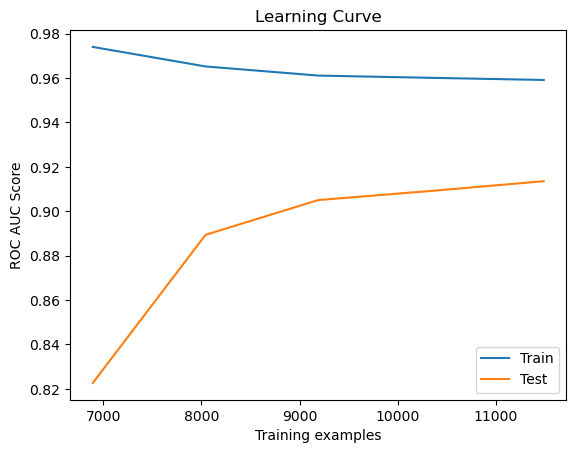

In [315]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=gbm,
    X=X_train_smote_new,
    y=y_train_smote,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy')

# Calculate mean train and test scores across CV folds
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel('Training examples')
plt.ylabel('ROC AUC Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

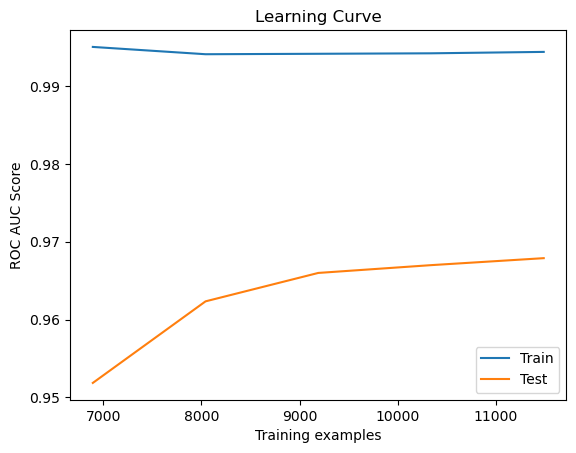

In [319]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=gbm,
    X=X_train_smote_new,
    y=y_train_smote,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='roc_auc')

# Calculate mean train and test scores across CV folds
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel('Training examples')
plt.ylabel('ROC AUC Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

### XGBoosting with feature selected

In [243]:
xgm= XGBClassifier(random_state=42,learning_rate=0.1,max_depth= 6,subsample=0.7,min_child_weight=50)

In [244]:
xgm.fit(X_train_smote_new,y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [245]:
evalNew(xgm)

Accuracy Score(Train set): 0.91
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.89
Precision Score (Test set):0.54
Recall Score (Train set):0.93
Recall Score (Test set):0.81
F1 Score (Train set):0.91
F1 Score (Test set):0.65
ROC AUC Score (Train-proba): 0.97
ROC AUC Score (Test-proba): 0.93
Confusion Matrix:
  [[6361  820]
 [ 504 6677]]


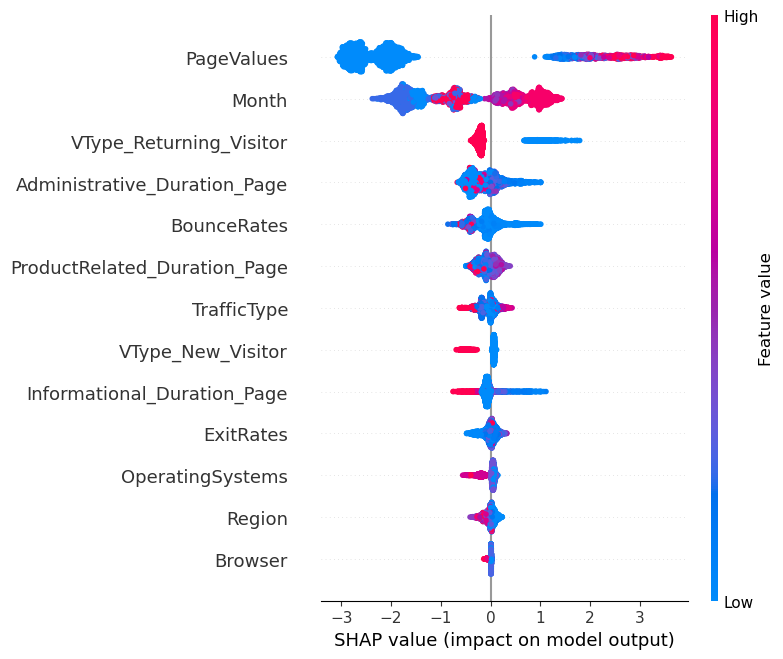

In [246]:
explainer = shap.TreeExplainer(xgm)
shap_values = explainer.shap_values(X_test_new)
shap.summary_plot(shap_values, X_test_new)

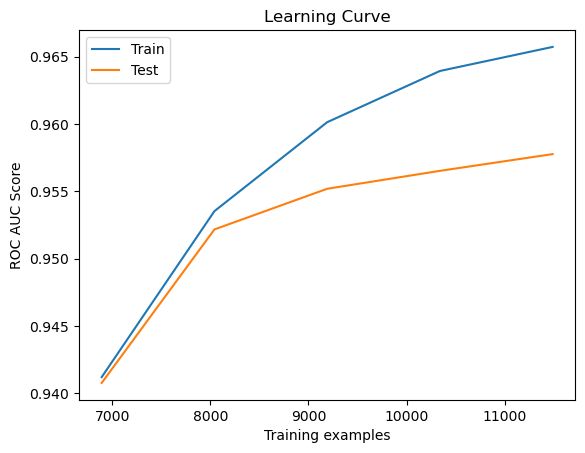

In [313]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgm,
    X=X_train_smote_new,
    y=y_train_smote,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='roc_auc')

# Calculate mean train and test scores across CV folds
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel('Training examples')
plt.ylabel('ROC AUC Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

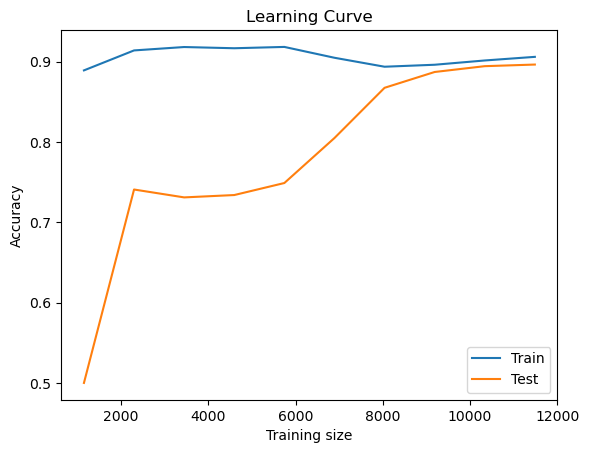

In [316]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgm,
    X=X_train_smote_new,
    y=y_train_smote,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy')

# Calculate mean train and test scores across CV folds
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

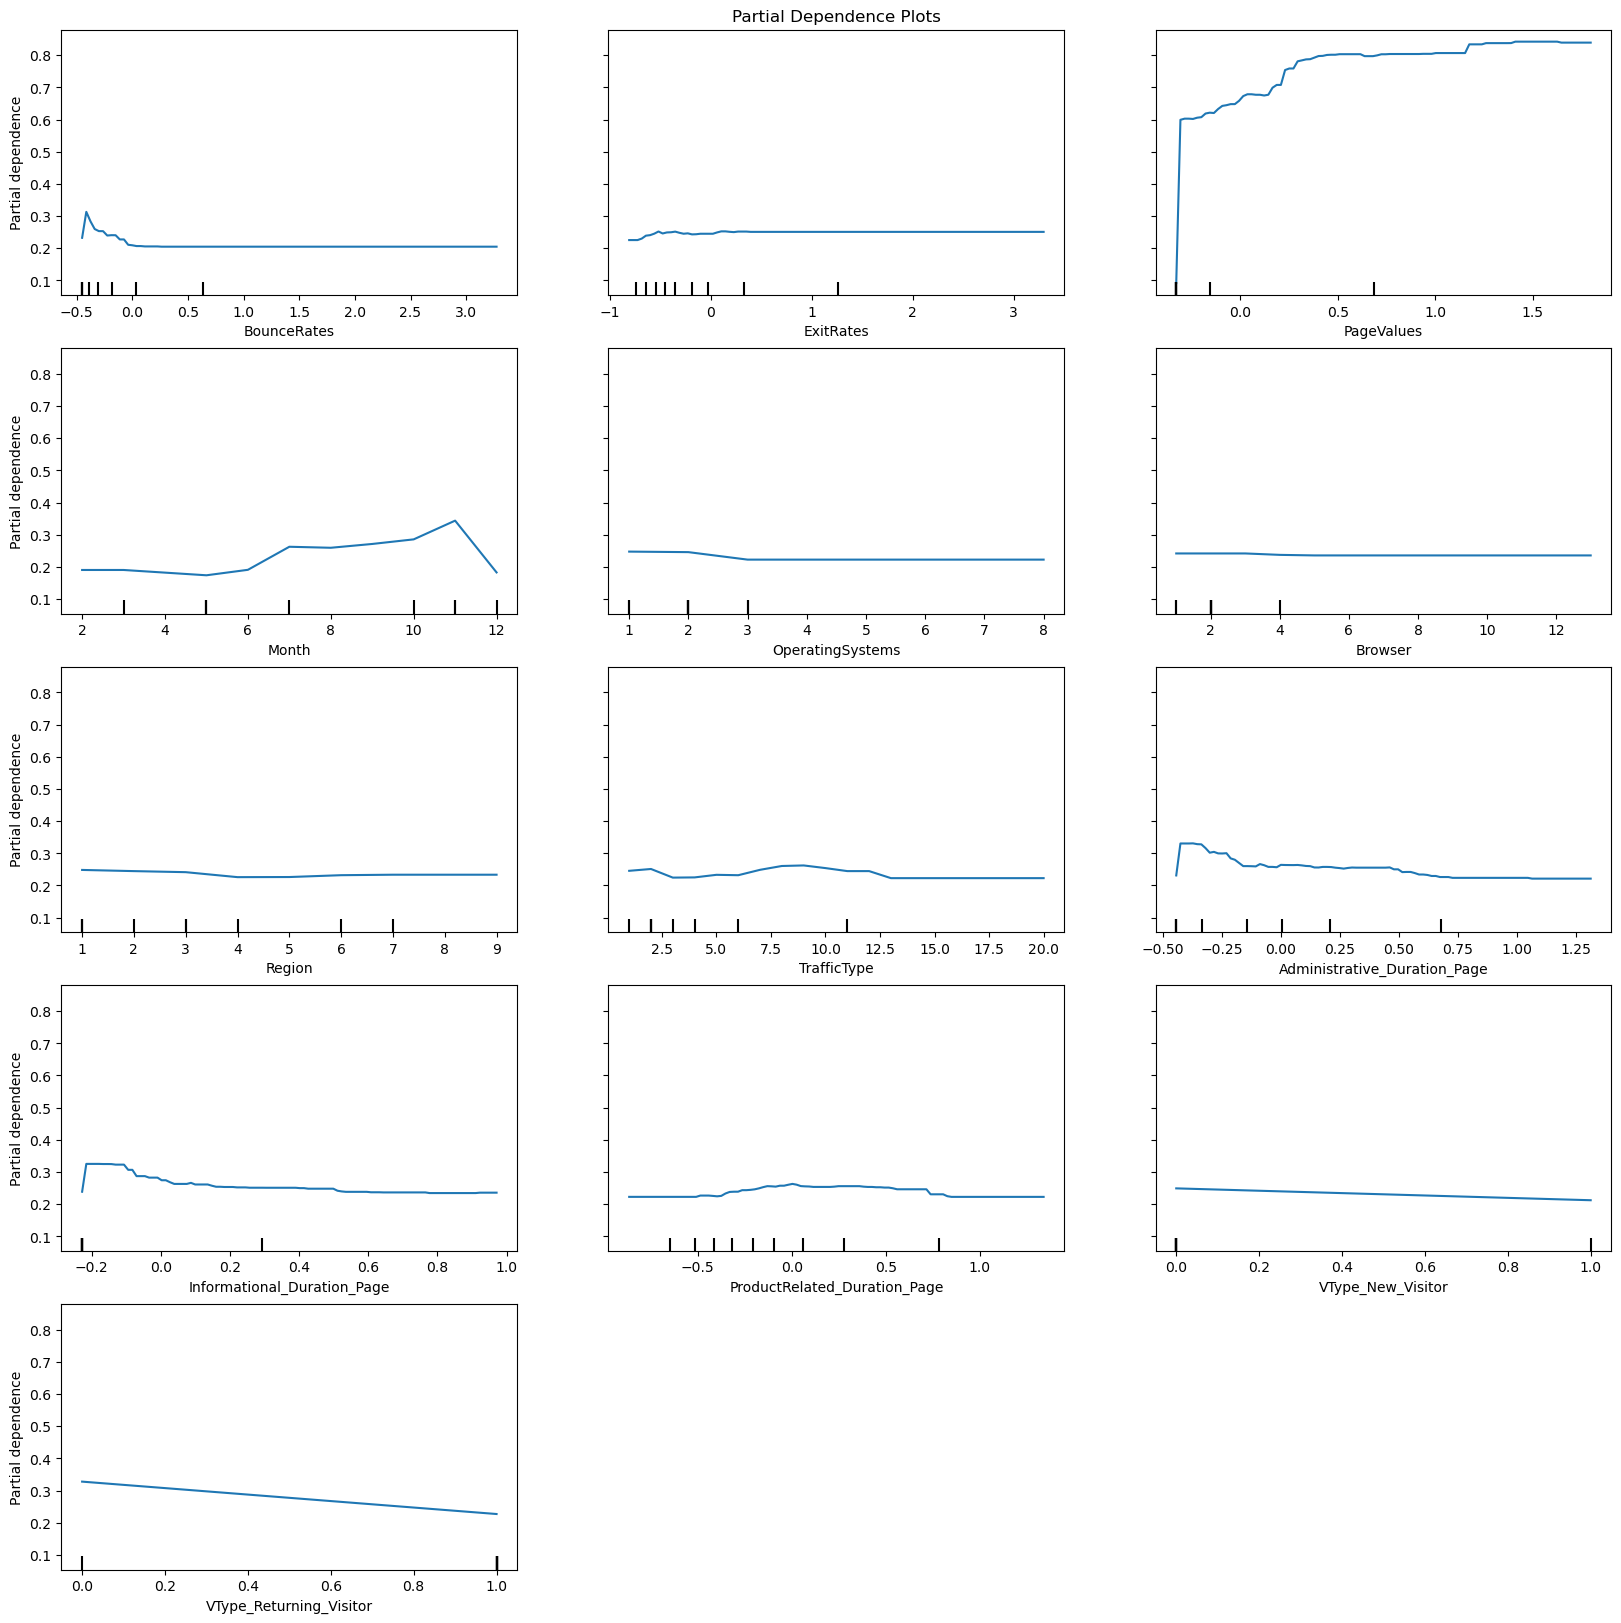

In [318]:
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(20,20 ))
ax.set_title("Partial Dependence Plots")
PartialDependenceDisplay.from_estimator(
    estimator=xgm,
    X=X_test_new,
    features=(0, 1, 2, 3,4,5,6,7,8,9,10,11,12),
    random_state=5,
    ax=ax,
)
plt.show()

### Random Forest with features selected

In [274]:
rfm= RandomForestClassifier(random_state=42,criterion='entropy',max_depth= 10,max_features='sqrt',min_samples_leaf=7,n_estimators=150)

In [275]:
rfm.fit(X_train_smote_new,y_train_smote)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=7,
                       n_estimators=150, random_state=42)

In [276]:
evalNew(rfm)

Accuracy Score(Train set): 0.91
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.90
Precision Score (Test set):0.54
Recall Score (Train set):0.92
Recall Score (Test set):0.80
F1 Score (Train set):0.91
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 0.98
ROC AUC Score (Test-proba): 0.92
Confusion Matrix:
  [[6428  753]
 [ 557 6624]]


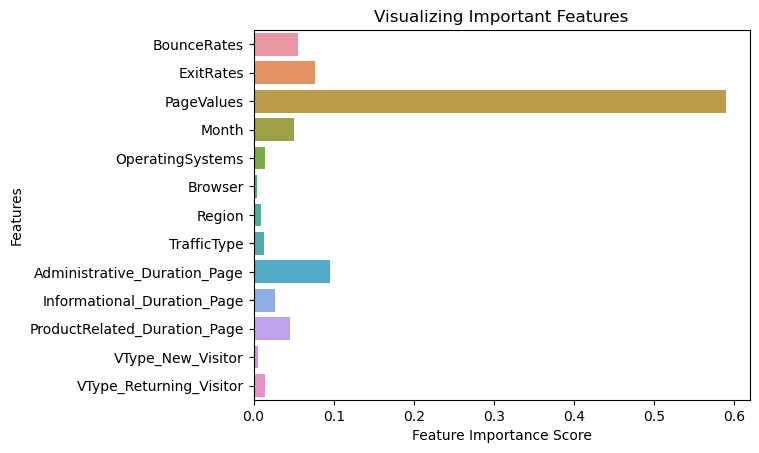

In [251]:
feature_imp1 = rfm.feature_importances_

sns.barplot(x=feature_imp1, y=X_test_new.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

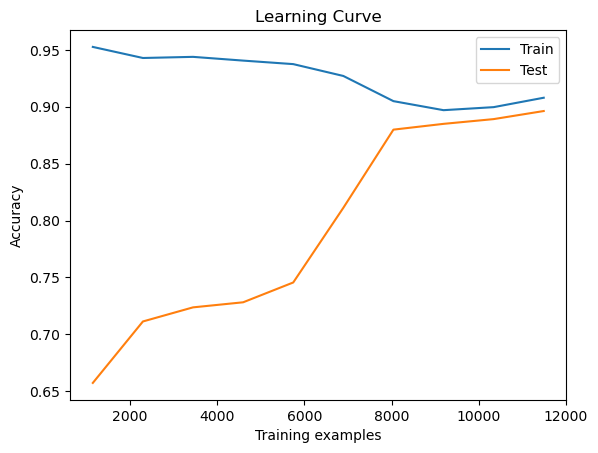

In [317]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=rfm,
    X=X_train_smote_new,
    y=y_train_smote,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy')

# Calculate mean train and test scores across CV folds
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

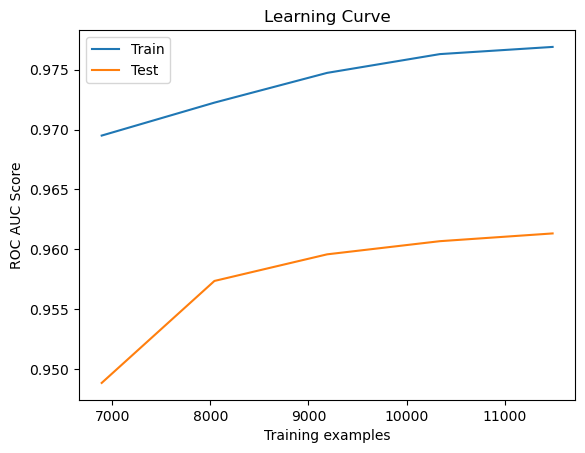

In [309]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=rfm,
    X=X_train_smote_new,
    y=y_train_smote,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='roc_auc')

# Calculate mean train and test scores across CV folds
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel('Training examples')
plt.ylabel('ROC AUC Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

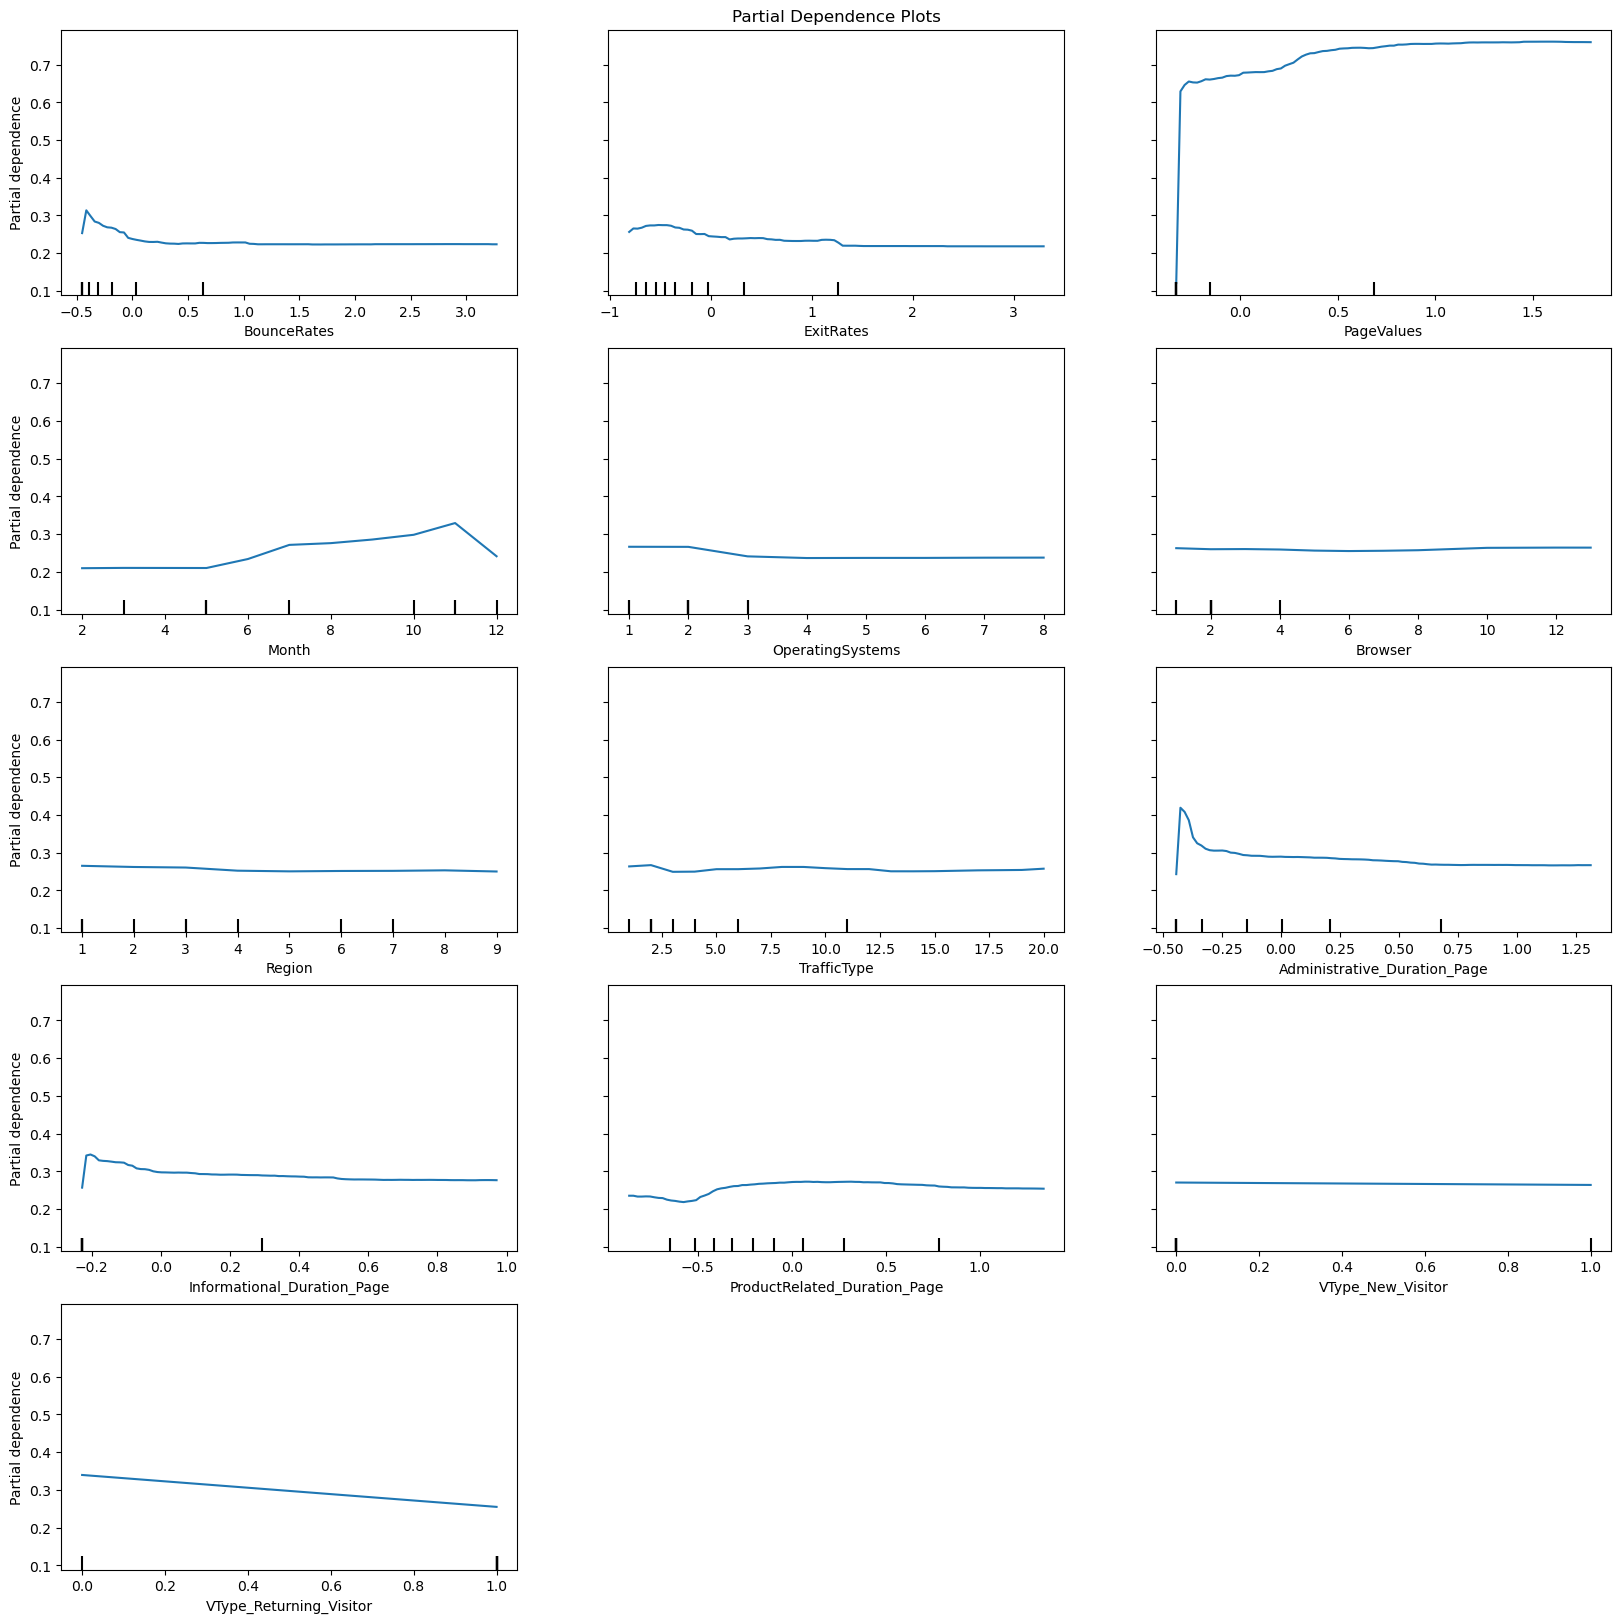

In [308]:
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(20,20 ))
ax.set_title("Partial Dependence Plots")
PartialDependenceDisplay.from_estimator(
    estimator=rfm,
    X=X_test_new,
    features=(0, 1, 2, 3,4,5,6,7,8,9,10,11,12),
    random_state=5,
    ax=ax,
)
plt.show()

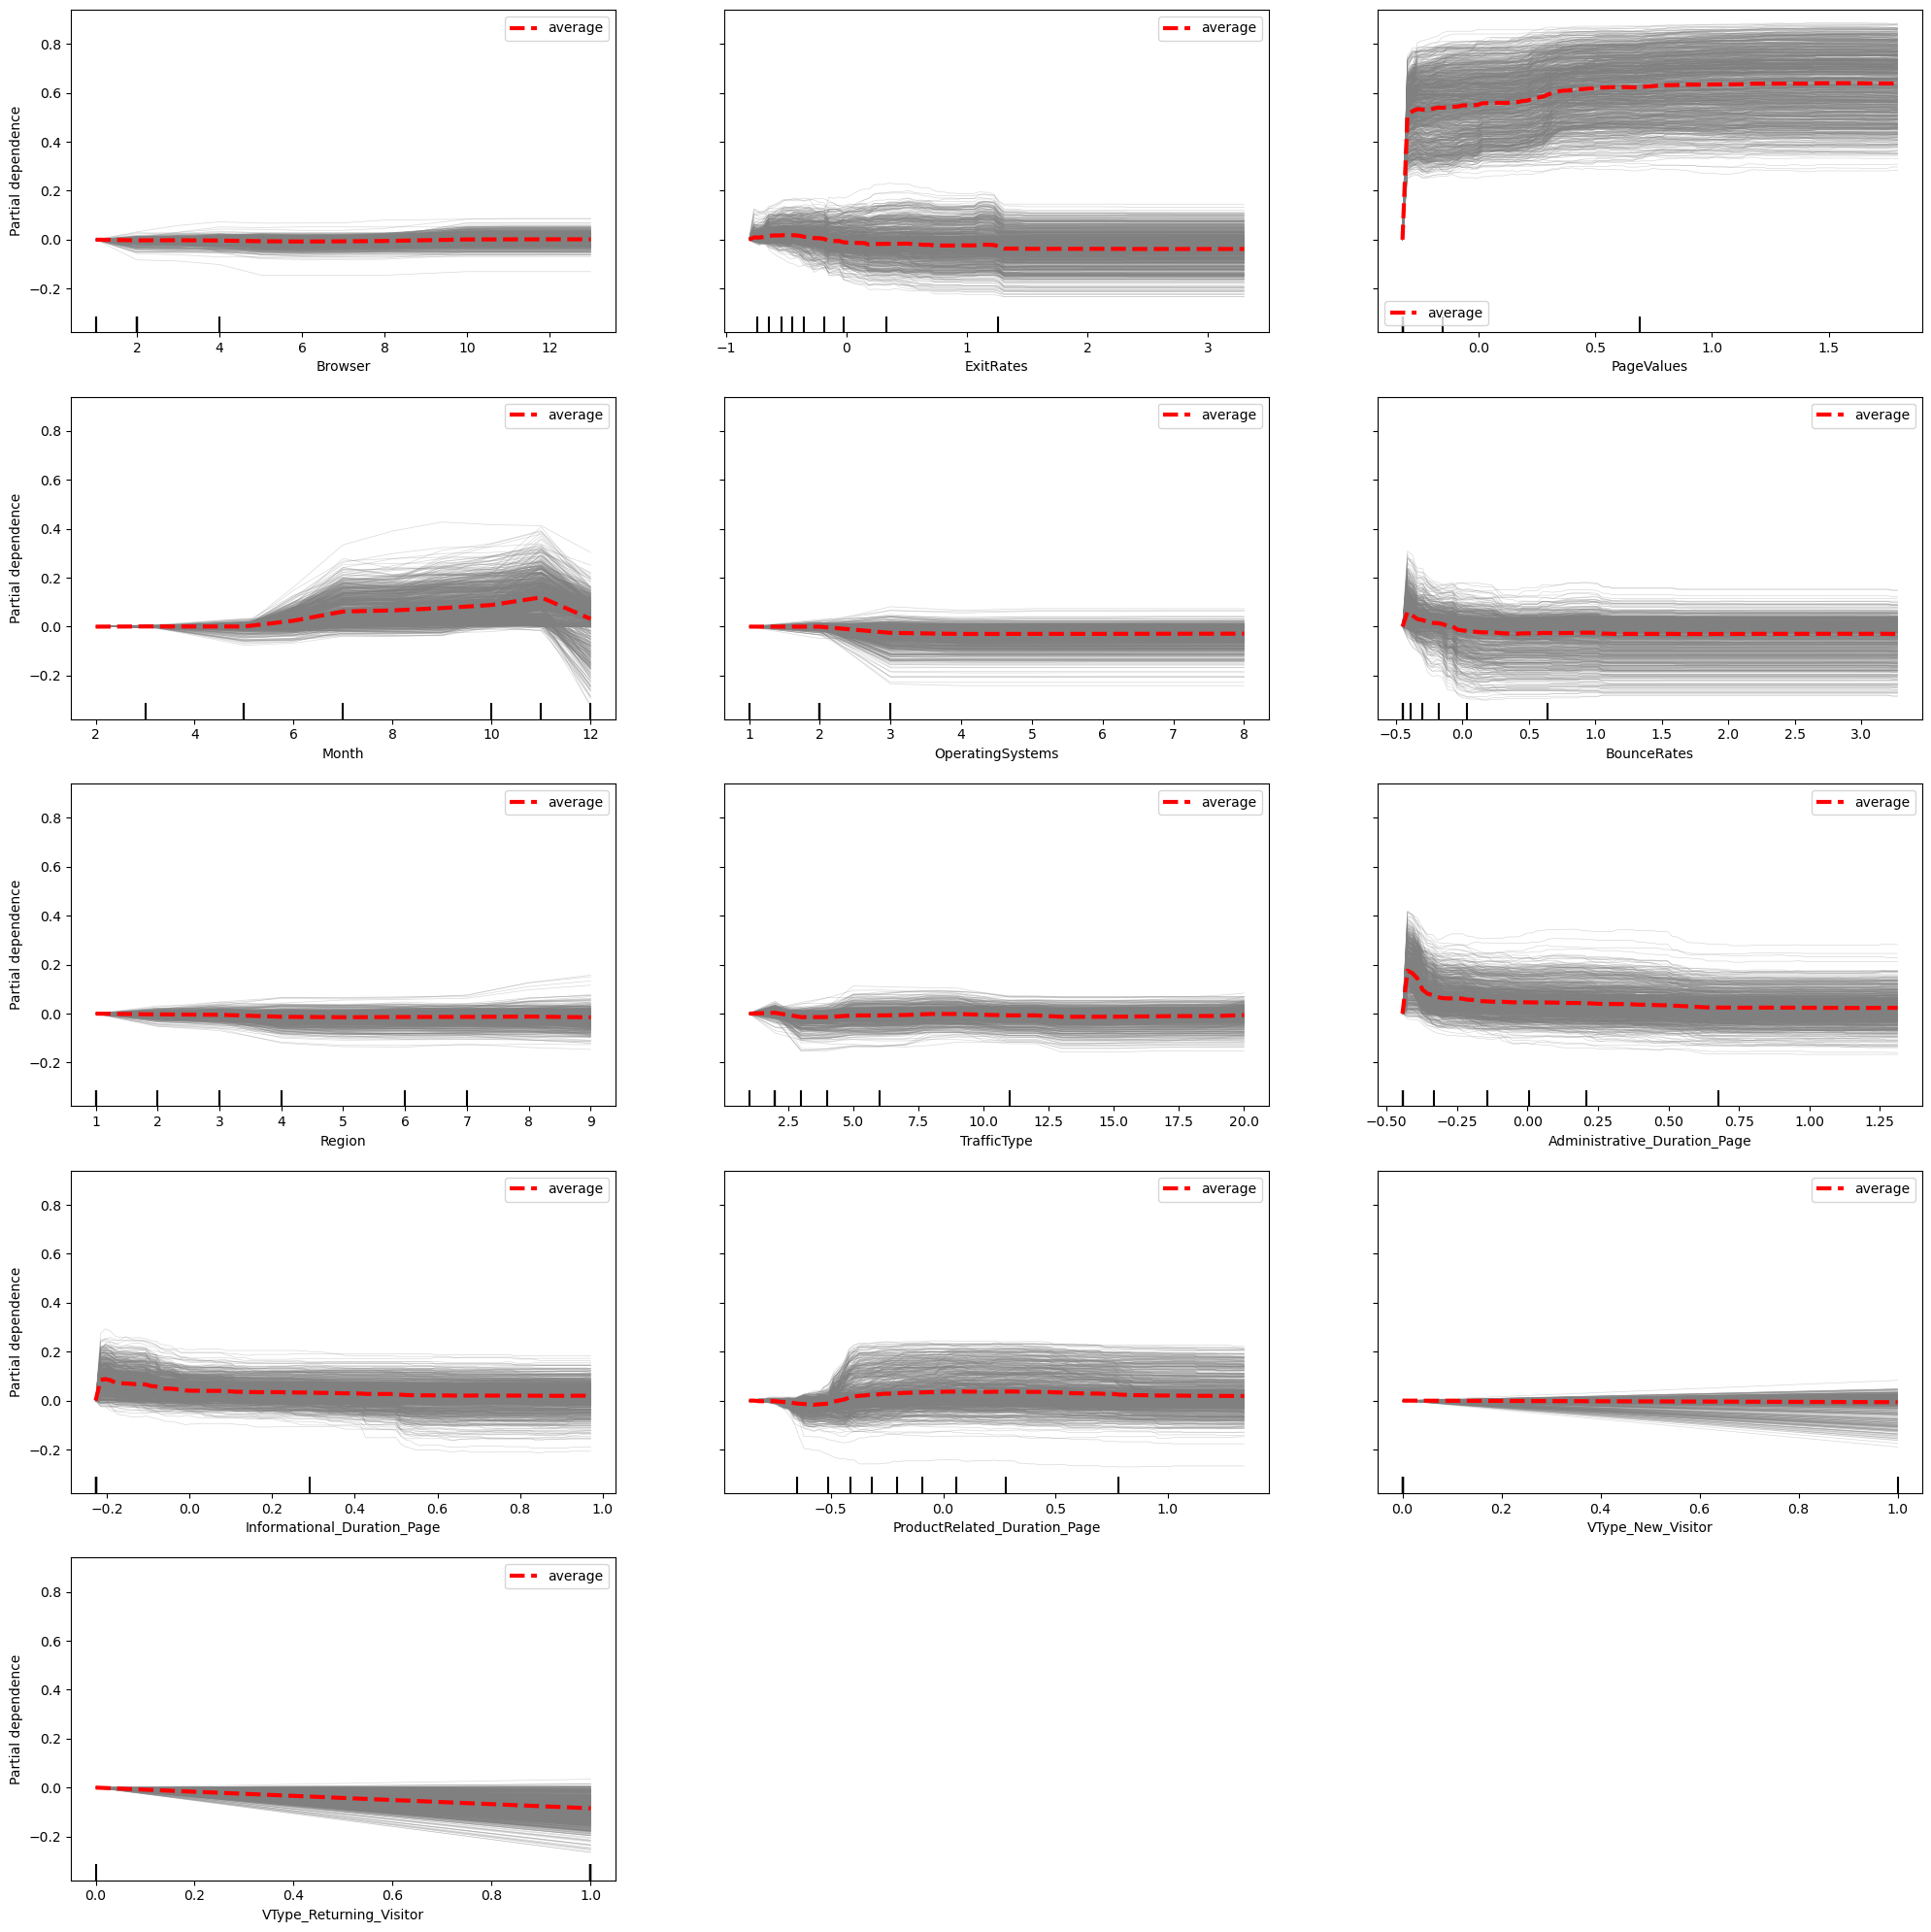

In [306]:
from sklearn.inspection import PartialDependenceDisplay
cols = X_test_new.columns
included_features_indices = np.argpartition(rfm.feature_importances_, -13)[-13:]

fig, ax = plt.subplots(figsize=(20, 20))
fig.set_tight_layout(True)  # Make sure labels of axes don't overlap in the final figure.
_ = PartialDependenceDisplay.from_estimator(estimator=rfm,
                                            ax=ax,
                                            X=X_test_new,
                                            features=[i for i in included_features_indices],
                                            feature_names=cols,
                                            n_cols=3,
                                            centered= True,
                                            kind='both',
                                            ice_lines_kw={'color': 'gray'},
                                            pd_line_kw={'color': 'red', 'linewidth': 3, 'linestyle': 'dashed'})